In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.models import load_model,Model
import random
import math
import threading
import time

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
import copy
x_tmp = copy.deepcopy(x_test[0])

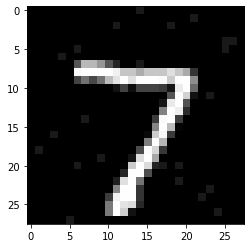

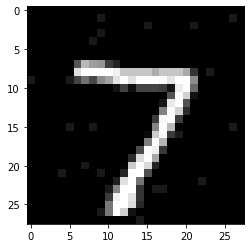

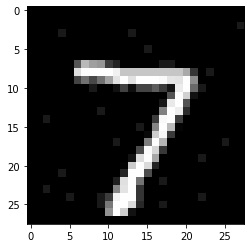

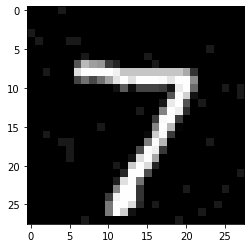

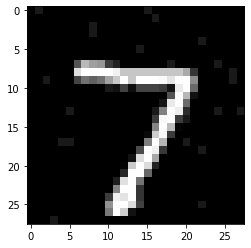

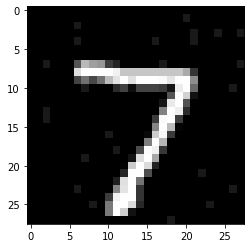

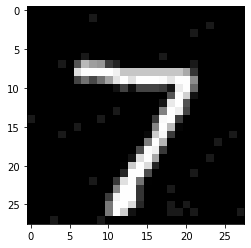

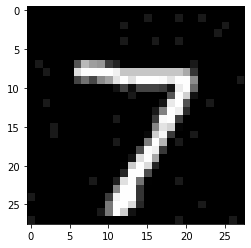

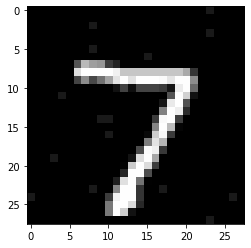

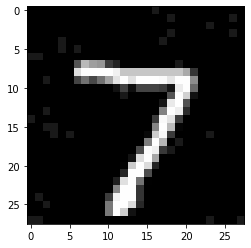

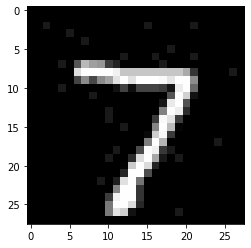

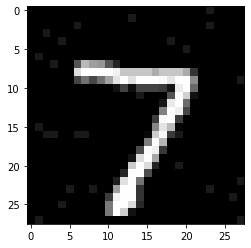

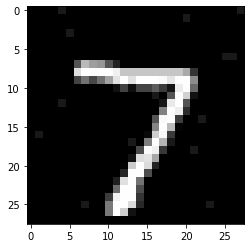

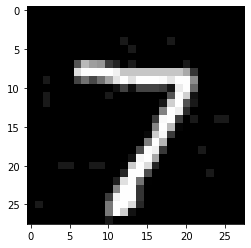

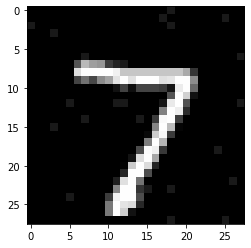

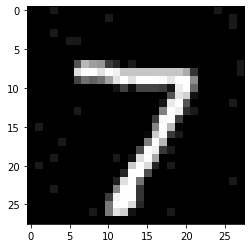

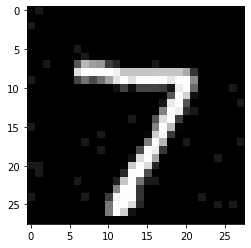

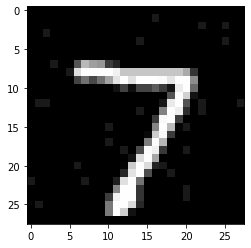

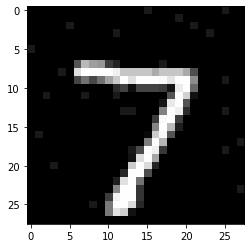

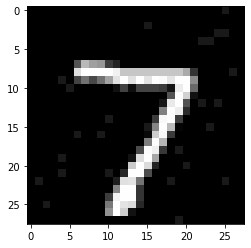

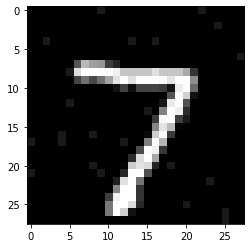

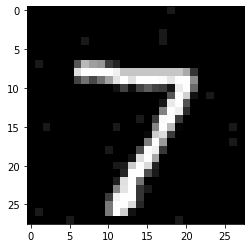

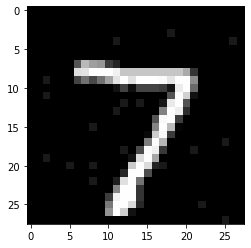

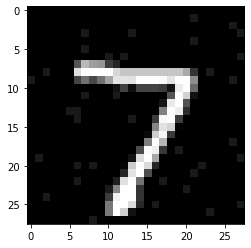

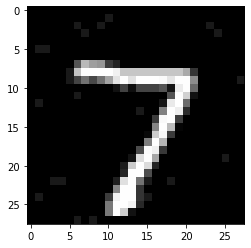

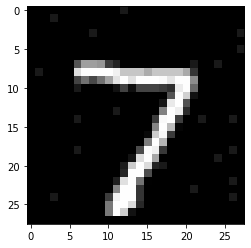

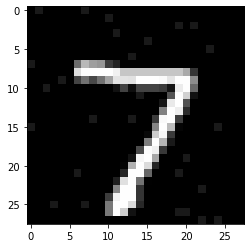

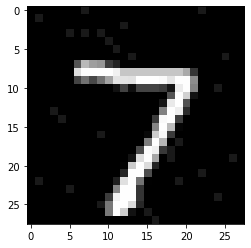

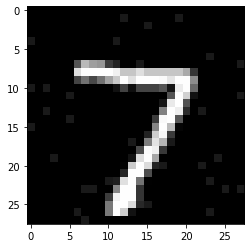

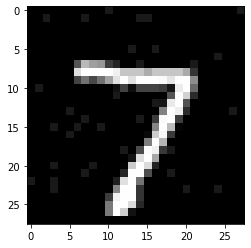

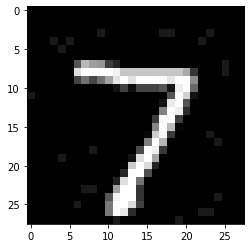

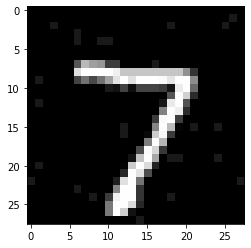

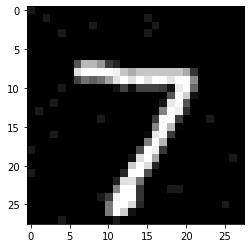

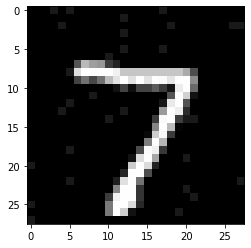

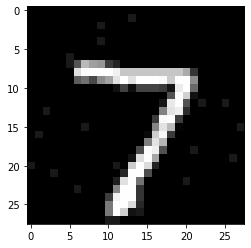

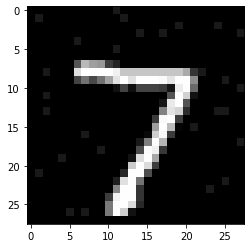

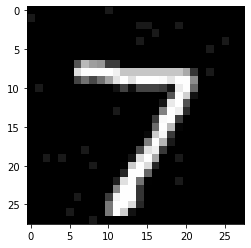

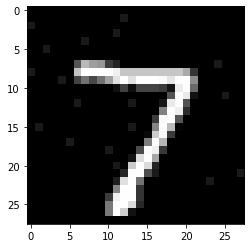

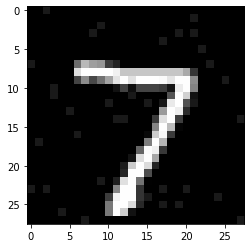

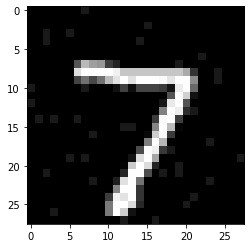

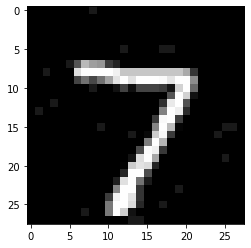

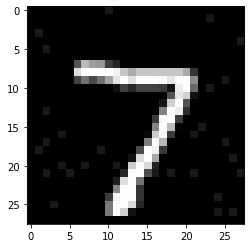

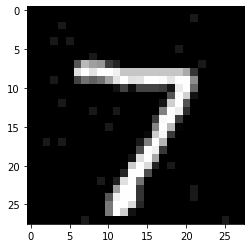

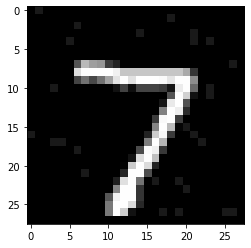

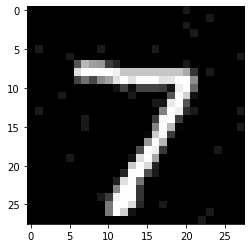

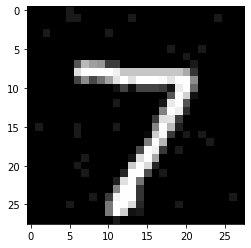

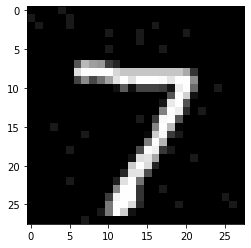

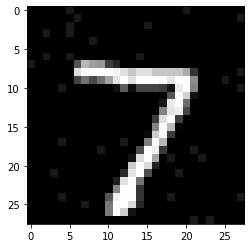

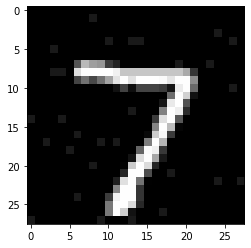

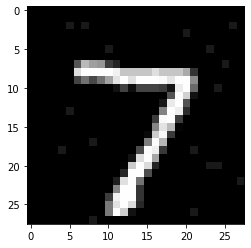

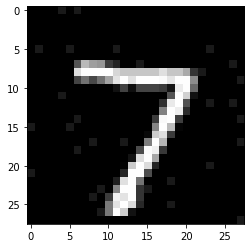

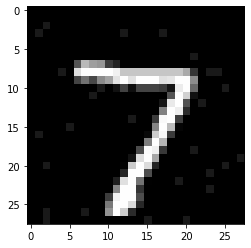

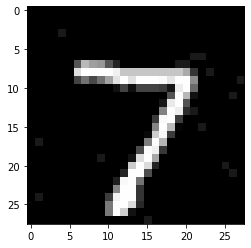

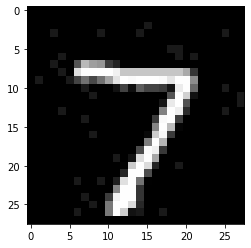

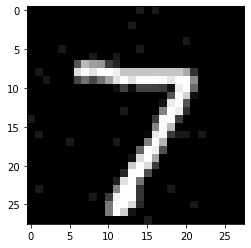

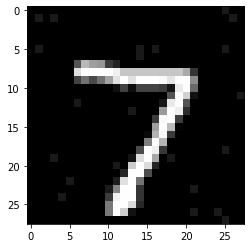

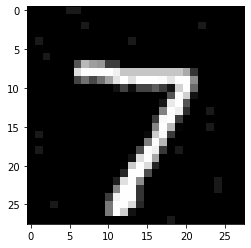

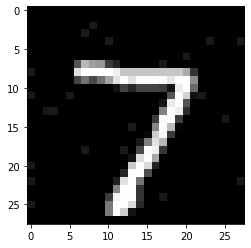

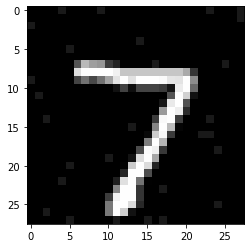

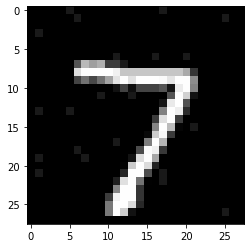

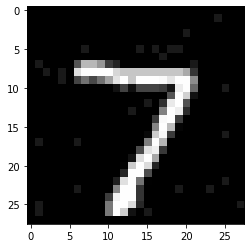

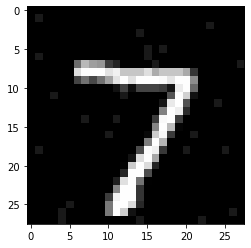

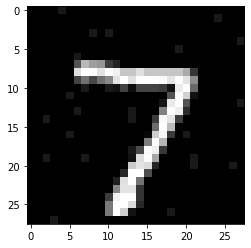

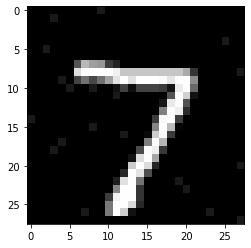

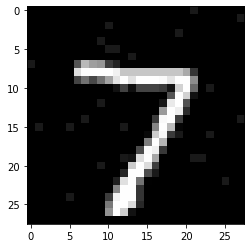

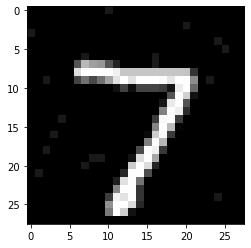

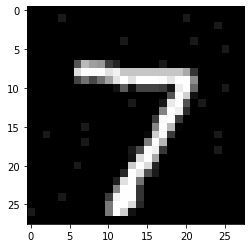

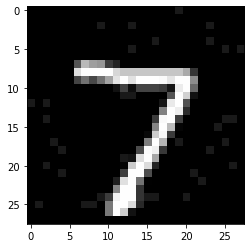

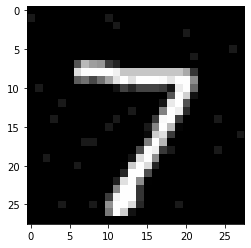

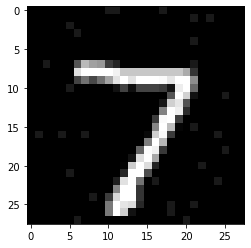

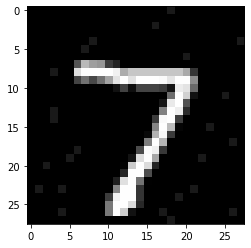

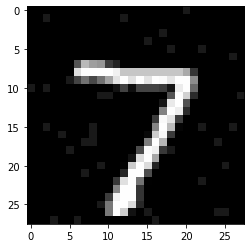

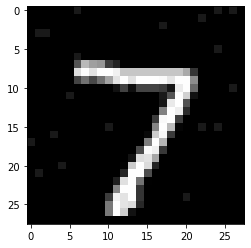

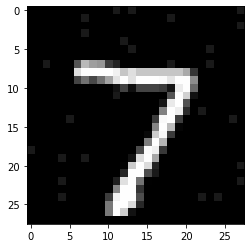

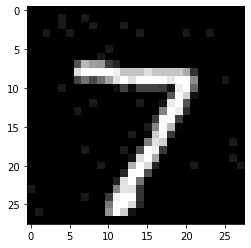

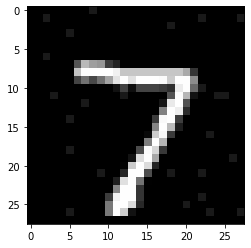

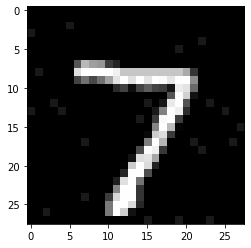

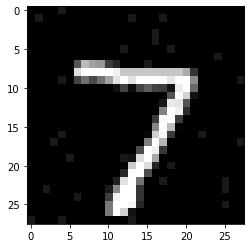

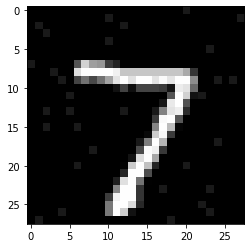

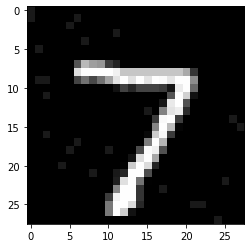

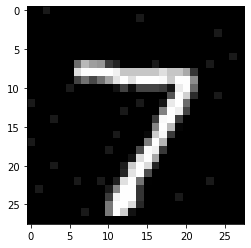

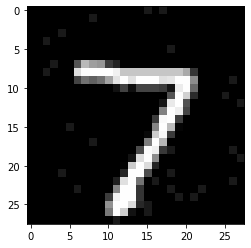

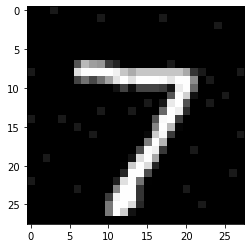

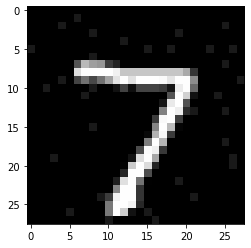

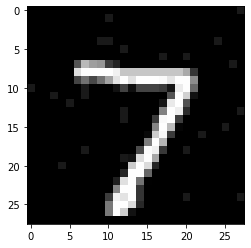

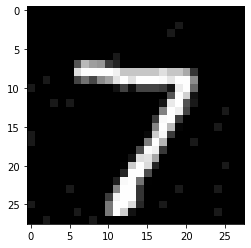

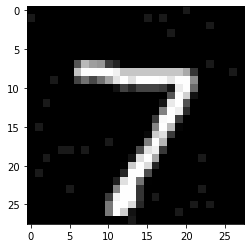

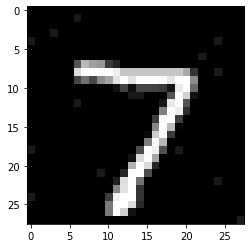

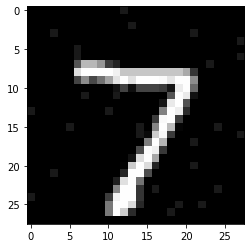

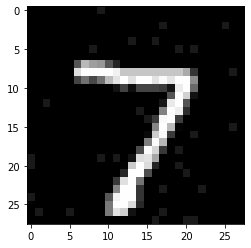

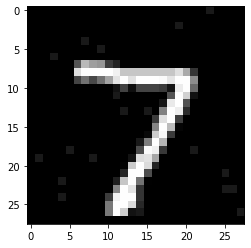

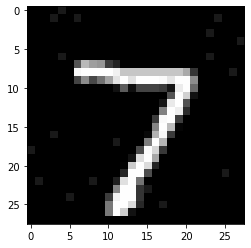

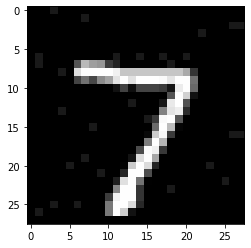

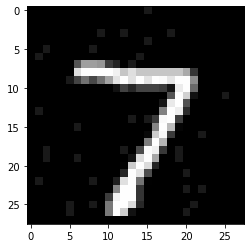

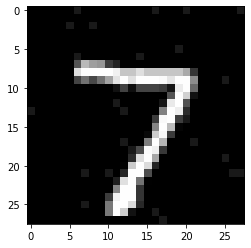

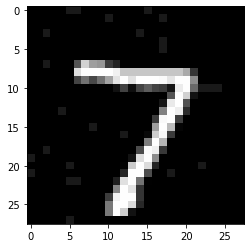

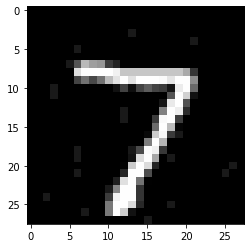

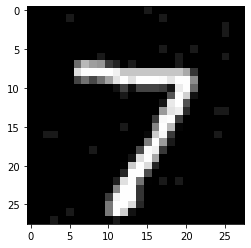

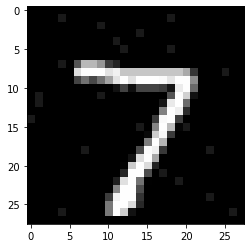

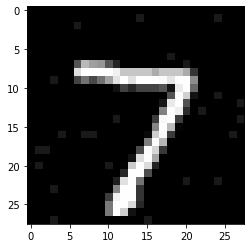

In [4]:
#产生扰动种群
x_des = []
for r in range(100):
    for i in range(28):
        for j in range(28):
            x= random.randint(0,10000)/10000
            if x <= 0.1:
                u = x_tmp[i,j] # 期望值μ
                sig = math.sqrt(0.2) # 标准差δ
                x_ = random.uniform(u - 3*sig, u + 3*sig)
                y_sig = np.exp(-(x_ - u) ** 2 /(2* sig **2))/(math.sqrt(2*math.pi)*sig)
                y_= random.randint(0,10000)/10000
                if y_ <= y_sig:
                    if x_test[0][i,j] <= 127:
                        x_tmp[i,j] += 255*0.1
                    elif x_test[0][i,j] > 127 and x_test[0][i,j] < 229:
                        y = random.randint(0,10000)/10000
                        if y <= 0.5:
                            x_tmp[i,j] += 255*0.1
                        else:
                            x_tmp[i,j] -= 255*0.1
                    elif x_test[0][i,j] >= 229:
                        x_tmp[i,j] -= 255*0.1
    x_t = x_tmp/255-x_test[0]/255
    #x_des.append(np.array (x_t.reshape(1,784)))
    x_des.append(np.array(x_t.reshape(1,784)))
    plt.imshow(x_tmp,cmap='gray')
    plt.show()
    x_tmp = copy.deepcopy(x_test[0])

In [4]:
x_train = x_train.reshape(60000,784)    # 将图片摊平，变成向量

In [5]:
x_test = x_test.reshape(10000,784)     # 对测试集进行同样的处理

In [6]:
x_train = x_train / 255
x_test = x_test / 255 

In [7]:
model = load_model('mnist_model.h5')

In [8]:
def Func(x):
    x_F = x[:]+x_test[0]
    result=model.predict(x_F.reshape(1,784))
    return result[0][7]

In [9]:
def Dis(x):   # 扰动值
    res = 0
    for i in range(784):
        l = x[i]
        res += l**2
    return res

In [11]:
# 攻击模块
class Atk(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Atk, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        self.cond.acquire()
        print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        #global best
        while GENERATION < MAX_GENERATION:
        #while Func(BEST_X) >= 0.35 or Dis(BEST_X) >= 6.5:
        #for t in range(5):
            #print(Func(BEST_X))
            DB = Dis(BEST_X)    # 存储上一代的扰动程度
            Db[:] = best[:]
            s = 1
            
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i])
                
                D_ = DIS_U[i] - DB
                # 变异的种子表现更好
                if FITS[i] >= FITS_U[i] and D_ < 0.1:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if FITS_U[i] < Func(BEST_X) and D_ < 0.1:
                        BEST_X = U[i, :]
            GENERATION += 1
            
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            #print("Db ","最优值：", Func(Db),"扰动程度：",Dis(Db))
            best[:] = Db[:]
            if Func(best) > 0.6:
                s -= 1     # 触发（检测此步骤是否有执行）
                best[:] = BEST_X[:]
                print("best ","最优值：", Func(best),"扰动程度：",Dis(best))
            if s == 1:
                best[:] = Db[:]
            
            if Func(BEST_X) <= 0.6:
                if Func(BEST_X) < Func(best) and Dis(BEST_X) < Dis(best):   # 保存最好的数值
                    s -= 1     # 触发（检测此步骤是否有执行）
                    #print("test-B","最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X))
                    #print("test-b","最优值：", Func(best),"扰动程度：",Dis(best))
                    best[:] = BEST_X[:]
                    print("best ","最优值：", Func(best),"扰动程度：",Dis(best))
            print(" ")        
            if s == 1:
                best[:] = Db[:]
            
            if Func(BEST_X) <= F:
                print("Resume")
                if D <= 4.0:
                    D += 0.3 
                self.cond.notify()  # 唤醒一个挂起的线程
                self.cond.wait()
        self.cond.release()


# 恢复模块
class Re(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Re, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        #time.sleep(1)
        self.cond.acquire()
        self.cond.wait()
        #print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        #global best
        while GENERATION < MAX_GENERATION:
        #while Func(BEST_X) >= 0.35 or Dis(BEST_X) >= 6.5:
        #for t in range(5):
            #print(Func(BEST_X))
            FB = Func(BEST_X)    # 存储上一代的置信度
            Fb[:] = best[:]
            s = 1
            
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i]) 
                F_ = FITS_U[i] - FB
                
                # 变异的种子表现更好
                #if FITS[i] >= FITS_U[i] and DIS[i] >= DIS_U[i]:
                if DIS[i] >= DIS_U[i] and F_ < 0.01:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if DIS_U[i] < Dis(BEST_X) and F_ < 0.01:
                        BEST_X = U[i, :]
            GENERATION += 1
            #print(F_)
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            #print("Fb ","最优值：", Func(Fb),"扰动程度：",Dis(Fb))
            best[:] = Fb[:]
            if Func(best) > 0.6:
                s -= 1     # 触发（检测此步骤是否有执行）
                best[:] = BEST_X[:]
                print("best ","最优值：", Func(best),"扰动程度：",Dis(best))
            if s == 1:
                best[:] = Fb[:]
            
            if Func(BEST_X) <= 0.6:
                if Func(BEST_X) < Func(best) and Dis(BEST_X) < Dis(best):   # 保存最好的数值
                    s -= 1     # 触发（检测此步骤是否有执行）
                    #print("test-B","最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X))
                    #print("test-b","最优值：", Func(best),"扰动程度：",Dis(best))
                    best[:] = BEST_X[:]
                    print("best ","最优值：", Func(best),"扰动程度：",Dis(best))
            print(" ")         
            if s == 1:
                best[:] = Fb[:]
            
            if Dis(BEST_X) <= D:
                print("Attack")
                if F > 0.3:
                    F -= 0.05
                self.cond.notify()
                self.cond.wait()
        self.cond.release()
        

In [12]:
MAX_GENERATION = 5000  # 最大迭代次数
GENERATION = 0  # 当前代数
L = 784  # 种子的维度
N = 100  # 种群规模
SIGMA = 0.333  # 缩放因子
CR = 0.1  # 交叉概率
F = 0.9   #置信度参数
D = 2.7   #扰动参数
cond = threading.Condition()
atk = Atk(cond, "Attack")
re = Re(cond, "Resume")
best = 0
GENERATION = 0  # 当前代数
BEST_X = 0
FITS = np.zeros(N)
FITS_U = np.zeros(N)
DIS = np.zeros(N)
DIS_U = np.zeros(N)
V = np.zeros((N, L))
U = np.zeros((N, L))
Db = np.zeros(L)
Fb = np.zeros(L)
# 1、初始化
X = np.concatenate(x_des, axis=0)
# 找出随机生成的最好的种子
for i in range(N):
    FITS[i] = Func(X[i])
# 找出最好的种子 适应度值最小
BEST_X = X[np.argmin(FITS)]
best = X[np.argmin(FITS)]
re.start()
atk.start()

#re.join()
#atk.join()

Attack
最优值： 0.99661726 扰动程度： 0.316321933871588 代数： 1
best  最优值： 0.9966642 扰动程度： 0.30992695117262603
 
最优值： 0.99661106 扰动程度： 0.31230463402979824 代数： 2
best  最优值： 0.99661106 扰动程度： 0.31230463402979824
 
最优值： 0.996572 扰动程度： 0.3496175777554884 代数： 3
best  最优值： 0.996572 扰动程度： 0.3496175777554884
 
最优值： 0.9963676 扰动程度： 0.3723402985459537 代数： 4
best  最优值： 0.9963676 扰动程度： 0.3723402985459537
 
最优值： 0.9963534 扰动程度： 0.3365509279162535 代数： 5
best  最优值： 0.9963534 扰动程度： 0.3365509279162535
 
最优值： 0.9961987 扰动程度： 0.42105149349487847 代数： 6
best  最优值： 0.9961987 扰动程度： 0.42105149349487847
 
最优值： 0.99609584 扰动程度： 0.4473104631305992 代数： 7
best  最优值： 0.99609584 扰动程度： 0.4473104631305992
 
最优值： 0.99565506 扰动程度： 0.518250711050892 代数： 8
best  最优值： 0.99565506 扰动程度： 0.518250711050892
 
最优值： 0.9956519 扰动程度： 0.5140991767402519 代数： 9
best  最优值： 0.9956519 扰动程度： 0.5140991767402519
 
最优值： 0.9954646 扰动程度： 0.5194610042989215 代数： 10
best  最优值： 0.9954646 扰动程度： 0.5194610042989215
 
最优值： 0.99544805 扰动程度： 0.5224194909840496 代数： 

最优值： 0.95440435 扰动程度： 2.543966542134435 代数： 88
best  最优值： 0.95440435 扰动程度： 2.543966542134435
 
最优值： 0.9536506 扰动程度： 2.4840532675759563 代数： 89
best  最优值： 0.9536506 扰动程度： 2.4840532675759563
 
最优值： 0.95298755 扰动程度： 2.5765862967143343 代数： 90
best  最优值： 0.95298755 扰动程度： 2.5765862967143343
 
最优值： 0.9513603 扰动程度： 2.6423325226409493 代数： 91
best  最优值： 0.9513603 扰动程度： 2.6423325226409493
 
最优值： 0.9501721 扰动程度： 2.6345233318443966 代数： 92
best  最优值： 0.9501721 扰动程度： 2.6345233318443966
 
最优值： 0.94970185 扰动程度： 2.6535585248903315 代数： 93
best  最优值： 0.94970185 扰动程度： 2.6535585248903315
 
最优值： 0.94812316 扰动程度： 2.6994981570191947 代数： 94
best  最优值： 0.94812316 扰动程度： 2.6994981570191947
 
最优值： 0.94812316 扰动程度： 2.6994981570191947 代数： 95
best  最优值： 0.94812316 扰动程度： 2.6994981570191947
 
最优值： 0.9469911 扰动程度： 2.761880313402163 代数： 96
best  最优值： 0.9469911 扰动程度： 2.761880313402163
 
最优值： 0.94348234 扰动程度： 2.8301985362805855 代数： 97
best  最优值： 0.94348234 扰动程度： 2.8301985362805855
 
最优值： 0.94377285 扰动程度： 2.9281330411486146 代

最优值： 0.88424176 扰动程度： 3.5179550559315844 代数： 174
best  最优值： 0.88424176 扰动程度： 3.5179550559315844
 
最优值： 0.8885406 扰动程度： 3.441628768366519 代数： 175
best  最优值： 0.8885406 扰动程度： 3.441628768366519
 
最优值： 0.88609266 扰动程度： 3.4265455324028453 代数： 176
best  最优值： 0.88609266 扰动程度： 3.4265455324028453
 
最优值： 0.88765866 扰动程度： 3.4107834697890356 代数： 177
best  最优值： 0.88765866 扰动程度： 3.4107834697890356
 
最优值： 0.89494354 扰动程度： 3.337963994280563 代数： 178
best  最优值： 0.89494354 扰动程度： 3.337963994280563
 
最优值： 0.89334065 扰动程度： 3.3710780215164333 代数： 179
best  最优值： 0.89334065 扰动程度： 3.3710780215164333
 
最优值： 0.89899135 扰动程度： 3.261158017490611 代数： 180
best  最优值： 0.89899135 扰动程度： 3.261158017490611
 
Attack
最优值： 0.8926482 扰动程度： 3.2903231068347942 代数： 181
best  最优值： 0.8926482 扰动程度： 3.2903231068347942
 
最优值： 0.88594526 扰动程度： 3.2974526935677004 代数： 182
best  最优值： 0.88594526 扰动程度： 3.2974526935677004
 
最优值： 0.885199 扰动程度： 3.3150196112285246 代数： 183
best  最优值： 0.885199 扰动程度： 3.3150196112285246
 
最优值： 0.88668954 扰动程度： 3.305

最优值： 0.75900644 扰动程度： 4.634985679439421 代数： 260
best  最优值： 0.75900644 扰动程度： 4.634985679439421
 
最优值： 0.76789653 扰动程度： 4.532428562844856 代数： 261
best  最优值： 0.76789653 扰动程度： 4.532428562844856
 
最优值： 0.77695274 扰动程度： 4.432120328743764 代数： 262
best  最优值： 0.77695274 扰动程度： 4.432120328743764
 
最优值： 0.77984697 扰动程度： 4.397311545231164 代数： 263
best  最优值： 0.77984697 扰动程度： 4.397311545231164
 
最优值： 0.77953947 扰动程度： 4.3205576832080235 代数： 264
best  最优值： 0.77953947 扰动程度： 4.3205576832080235
 
最优值： 0.78235346 扰动程度： 4.282762409770261 代数： 265
best  最优值： 0.78235346 扰动程度： 4.282762409770261
 
最优值： 0.7889035 扰动程度： 4.2294763089778895 代数： 266
best  最优值： 0.7889035 扰动程度： 4.2294763089778895
 
最优值： 0.7918593 扰动程度： 4.197463978558618 代数： 267
best  最优值： 0.7918593 扰动程度： 4.197463978558618
 
最优值： 0.8012644 扰动程度： 4.150910789152483 代数： 268
best  最优值： 0.8012644 扰动程度： 4.150910789152483
 
最优值： 0.80284685 扰动程度： 4.102946637311436 代数： 269
best  最优值： 0.80284685 扰动程度： 4.102946637311436
 
最优值： 0.809 扰动程度： 4.067801063500275 代数： 270

最优值： 0.6486584 扰动程度： 5.502140705464855 代数： 347
best  最优值： 0.6486584 扰动程度： 5.502140705464855
 
Resume
最优值： 0.65101564 扰动程度： 5.4889446151921994 代数： 348
best  最优值： 0.65101564 扰动程度： 5.4889446151921994
 
最优值： 0.65945613 扰动程度： 5.399614073843934 代数： 349
best  最优值： 0.65945613 扰动程度： 5.399614073843934
 
最优值： 0.6672313 扰动程度： 5.2284722922207365 代数： 350
best  最优值： 0.6672313 扰动程度： 5.2284722922207365
 
最优值： 0.6771799 扰动程度： 5.087891985367389 代数： 351
best  最优值： 0.6771799 扰动程度： 5.087891985367389
 
最优值： 0.67945313 扰动程度： 5.066707302795053 代数： 352
best  最优值： 0.67945313 扰动程度： 5.066707302795053
 
最优值： 0.6804993 扰动程度： 5.042771973928799 代数： 353
best  最优值： 0.6804993 扰动程度： 5.042771973928799
 
最优值： 0.6878677 扰动程度： 5.01036213693826 代数： 354
best  最优值： 0.6878677 扰动程度： 5.01036213693826
 
最优值： 0.6920879 扰动程度： 4.952814903087324 代数： 355
best  最优值： 0.6920879 扰动程度： 4.952814903087324
 
最优值： 0.7012399 扰动程度： 4.896264613429414 代数： 356
best  最优值： 0.7012399 扰动程度： 4.896264613429414
 
最优值： 0.7034497 扰动程度： 4.858364403257017 代数： 35

最优值： 0.74093026 扰动程度： 4.2048474096310935 代数： 452
 
最优值： 0.7390597 扰动程度： 4.183327000959295 代数： 453
 
Attack
最优值： 0.73555213 扰动程度： 4.254071221200539 代数： 454
 
最优值： 0.7299677 扰动程度： 4.344310915586086 代数： 455
 
最优值： 0.7140615 扰动程度： 4.406521485574975 代数： 456
 
最优值： 0.70730305 扰动程度： 4.502960080134674 代数： 457
 
最优值： 0.69631314 扰动程度： 4.470217054020746 代数： 458
 
最优值： 0.69613415 扰动程度： 4.475793490628686 代数： 459
 
最优值： 0.69399375 扰动程度： 4.487350556020566 代数： 460
 
最优值： 0.6928437 扰动程度： 4.559460840870552 代数： 461
 
最优值： 0.6892845 扰动程度： 4.590893289450069 代数： 462
 
最优值： 0.6775015 扰动程度： 4.658536164847277 代数： 463
 
最优值： 0.67753434 扰动程度： 4.678491663994387 代数： 464
 
最优值： 0.6719109 扰动程度： 4.720363575564286 代数： 465
 
最优值： 0.6621576 扰动程度： 4.808345377353143 代数： 466
 
最优值： 0.65165025 扰动程度： 4.901971128791283 代数： 467
 
最优值： 0.64855325 扰动程度： 4.934032678940271 代数： 468
 
最优值： 0.63751704 扰动程度： 5.011757342690761 代数： 469
 
最优值： 0.6365101 扰动程度： 5.023955297553587 代数： 470
 
最优值： 0.6341351 扰动程度： 5.057414254384528 代数： 471
 
最优

最优值： 0.6574792 扰动程度： 4.612117344829081 代数： 614
 
最优值： 0.64502674 扰动程度： 4.685704013302271 代数： 615
 
最优值： 0.6426334 扰动程度： 4.700532333300186 代数： 616
 
最优值： 0.63264394 扰动程度： 4.7830957486848895 代数： 617
 
最优值： 0.6321719 扰动程度： 4.788243975478284 代数： 618
 
最优值： 0.6289336 扰动程度： 4.830021292389653 代数： 619
 
最优值： 0.62207896 扰动程度： 4.833826176770293 代数： 620
 
最优值： 0.6168228 扰动程度： 4.902055067678748 代数： 621
 
最优值： 0.6008268 扰动程度： 4.953329549401823 代数： 622
 
最优值： 0.59787107 扰动程度： 4.923933007981051 代数： 623
 
最优值： 0.60001755 扰动程度： 4.9020152816424964 代数： 624
 
最优值： 0.59717315 扰动程度： 4.933191250496645 代数： 625
 
最优值： 0.5926606 扰动程度： 4.966771333634875 代数： 626
 
最优值： 0.58605176 扰动程度： 5.059026493824665 代数： 627
 
最优值： 0.5795593 扰动程度： 5.078524975144214 代数： 628
 
最优值： 0.57524073 扰动程度： 5.106558516879312 代数： 629
 
最优值： 0.57468915 扰动程度： 5.115746814802014 代数： 630
 
最优值： 0.5727157 扰动程度： 5.130745128105335 代数： 631
best  最优值： 0.5727157 扰动程度： 5.130745128105335
 
最优值： 0.5690326 扰动程度： 5.212867312639303 代数： 632
 
最优值： 0.563165

最优值： 0.47608894 扰动程度： 5.680958075769121 代数： 777
 
最优值： 0.48448187 扰动程度： 5.6016226004078105 代数： 778
 
最优值： 0.4871079 扰动程度： 5.587200487964152 代数： 779
 
最优值： 0.48987752 扰动程度： 5.58469065790828 代数： 780
 
最优值： 0.4977393 扰动程度： 5.473998627810254 代数： 781
 
最优值： 0.49223346 扰动程度： 5.458272470063616 代数： 782
 
最优值： 0.5015751 扰动程度： 5.398069179014611 代数： 783
 
最优值： 0.50276726 扰动程度： 5.392639535730042 代数： 784
 
最优值： 0.4989749 扰动程度： 5.3903900819530195 代数： 785
 
最优值： 0.50879616 扰动程度： 5.361769049860899 代数： 786
 
最优值： 0.5150597 扰动程度： 5.312379910837058 代数： 787
 
最优值： 0.52160287 扰动程度： 5.280970555143658 代数： 788
 
最优值： 0.5283233 扰动程度： 5.188538542705438 代数： 789
 
最优值： 0.53180236 扰动程度： 5.172409538311783 代数： 790
 
最优值： 0.53883684 扰动程度： 5.12200360542627 代数： 791
 
最优值： 0.5477059 扰动程度： 5.093061927888664 代数： 792
 
最优值： 0.5621327 扰动程度： 5.035429779862338 代数： 793
 
最优值： 0.57137406 扰动程度： 4.966595371205088 代数： 794
 
最优值： 0.571523 扰动程度： 4.94381949928789 代数： 795
 
最优值： 0.5771978 扰动程度： 4.949117977943825 代数： 796
 
最优值： 0.57259

最优值： 0.5853872 扰动程度： 4.588988757907302 代数： 940
 
最优值： 0.5944382 扰动程度： 4.577210960440068 代数： 941
 
最优值： 0.59164846 扰动程度： 4.563550286628877 代数： 942
 
最优值： 0.5965661 扰动程度： 4.553279928915094 代数： 943
 
最优值： 0.5996434 扰动程度： 4.510439301486664 代数： 944
 
最优值： 0.60382956 扰动程度： 4.496238866289886 代数： 945
 
最优值： 0.6079825 扰动程度： 4.485860140734624 代数： 946
 
最优值： 0.60931313 扰动程度： 4.471194450376185 代数： 947
 
最优值： 0.6185857 扰动程度： 4.456811590707277 代数： 948
 
最优值： 0.62760925 扰动程度： 4.429694175514195 代数： 949
 
最优值： 0.62790453 扰动程度： 4.362122669662135 代数： 950
 
最优值： 0.63635516 扰动程度： 4.352236699838215 代数： 951
 
最优值： 0.63996446 扰动程度： 4.310534414162213 代数： 952
 
最优值： 0.64292806 扰动程度： 4.305702242553977 代数： 953
 
最优值： 0.6462536 扰动程度： 4.251823984544787 代数： 954
 
最优值： 0.65562433 扰动程度： 4.229833858744006 代数： 955
 
最优值： 0.65803695 扰动程度： 4.202272837099361 代数： 956
 
最优值： 0.65944904 扰动程度： 4.1884525142478495 代数： 957
 
Attack
最优值： 0.6431017 扰动程度： 4.278707275003191 代数： 958
 
最优值： 0.6310423 扰动程度： 4.351480110931032 代数： 959
 
最

最优值： 0.59820384 扰动程度： 4.4055412014560655 代数： 1103
 
最优值： 0.58182347 扰动程度： 4.505179014200545 代数： 1104
 
最优值： 0.5836667 扰动程度： 4.500628637041017 代数： 1105
 
最优值： 0.5811862 扰动程度： 4.5185165417764965 代数： 1106
 
最优值： 0.5773499 扰动程度： 4.605172812034226 代数： 1107
 
最优值： 0.5660613 扰动程度： 4.651277615185435 代数： 1108
 
最优值： 0.55276936 扰动程度： 4.672896102777884 代数： 1109
 
最优值： 0.549043 扰动程度： 4.761701049343921 代数： 1110
 
最优值： 0.52967644 扰动程度： 4.861537958741062 代数： 1111
 
最优值： 0.52856416 扰动程度： 4.8925000726794945 代数： 1112
 
最优值： 0.5266742 扰动程度： 4.944742816492581 代数： 1113
 
最优值： 0.52145416 扰动程度： 4.875473942262756 代数： 1114
 
最优值： 0.5220853 扰动程度： 4.938639313296881 代数： 1115
 
最优值： 0.5139478 扰动程度： 4.987647204560732 代数： 1116
 
最优值： 0.49910918 扰动程度： 5.083133249254525 代数： 1117
 
最优值： 0.4965676 扰动程度： 5.099255981559402 代数： 1118
 
最优值： 0.48593953 扰动程度： 5.152436105569124 代数： 1119
 
最优值： 0.4863583 扰动程度： 5.1855192941284916 代数： 1120
 
最优值： 0.4793956 扰动程度： 5.230332816957762 代数： 1121
 
最优值： 0.4692413 扰动程度： 5.324735953268764 

最优值： 0.4662875 扰动程度： 5.197526850228157 代数： 1264
 
最优值： 0.46389964 扰动程度： 5.283559233026941 代数： 1265
 
最优值： 0.4418594 扰动程度： 5.374324034466069 代数： 1266
 
最优值： 0.44096538 扰动程度： 5.374280492856372 代数： 1267
 
最优值： 0.4410022 扰动程度： 5.374734614318284 代数： 1268
 
最优值： 0.42935172 扰动程度： 5.455949982803242 代数： 1269
 
最优值： 0.42277467 扰动程度： 5.496592792353638 代数： 1270
 
最优值： 0.41968843 扰动程度： 5.511724071523558 代数： 1271
 
最优值： 0.4181729 扰动程度： 5.5207669236118635 代数： 1272
 
最优值： 0.40502983 扰动程度： 5.646313094288894 代数： 1273
 
最优值： 0.4073592 扰动程度： 5.609314250803383 代数： 1274
 
最优值： 0.39514452 扰动程度： 5.653509737272238 代数： 1275
 
最优值： 0.39559448 扰动程度： 5.651705561650903 代数： 1276
 
最优值： 0.3950082 扰动程度： 5.68045826092139 代数： 1277
 
最优值： 0.39336377 扰动程度： 5.6906617743437495 代数： 1278
 
最优值： 0.3927336 扰动程度： 5.6937628098975654 代数： 1279
 
最优值： 0.38490582 扰动程度： 5.766786880274018 代数： 1280
 
最优值： 0.3796398 扰动程度： 5.780535150942661 代数： 1281
 
最优值： 0.37894243 扰动程度： 5.844505919713603 代数： 1282
 
最优值： 0.37331006 扰动程度： 5.9331914033450

最优值： 0.29856032 扰动程度： 6.3565246091800764 代数： 1425
 
Resume
最优值： 0.3028768 扰动程度： 6.278790250745347 代数： 1426
 
最优值： 0.30724084 扰动程度： 6.252975124980068 代数： 1427
 
最优值： 0.313583 扰动程度： 6.225303480203866 代数： 1428
 
最优值： 0.3172946 扰动程度： 6.124903196501225 代数： 1429
 
最优值： 0.32438055 扰动程度： 6.03428793600404 代数： 1430
 
最优值： 0.33354232 扰动程度： 5.983684801773137 代数： 1431
 
最优值： 0.33910117 扰动程度： 5.91725266420675 代数： 1432
 
最优值： 0.34668085 扰动程度： 5.8448922222226996 代数： 1433
 
最优值： 0.35460398 扰动程度： 5.789260198970826 代数： 1434
 
最优值： 0.36360857 扰动程度： 5.747373276121037 代数： 1435
 
最优值： 0.3671516 扰动程度： 5.689134980083468 代数： 1436
 
最优值： 0.36829576 扰动程度： 5.679903836366191 代数： 1437
 
最优值： 0.36659417 扰动程度： 5.664473628654148 代数： 1438
 
最优值： 0.37460232 扰动程度： 5.598844147801531 代数： 1439
 
最优值： 0.37948287 扰动程度： 5.540840742389881 代数： 1440
 
最优值： 0.38759238 扰动程度： 5.47130084875507 代数： 1441
 
最优值： 0.3956421 扰动程度： 5.459963311029794 代数： 1442
 
最优值： 0.40256295 扰动程度： 5.404307786574282 代数： 1443
 
最优值： 0.4110652 扰动程度： 5.42233282

最优值： 0.51834065 扰动程度： 4.600106488701183 代数： 1585
 
最优值： 0.5281827 扰动程度： 4.543573425817747 代数： 1586
 
最优值： 0.53147215 扰动程度： 4.5450258305023254 代数： 1587
 
最优值： 0.5390993 扰动程度： 4.498873522309941 代数： 1588
 
最优值： 0.54321533 扰动程度： 4.468763985048176 代数： 1589
 
最优值： 0.55286247 扰动程度： 4.4418755618562 代数： 1590
 
最优值： 0.5495358 扰动程度： 4.437233457433896 代数： 1591
 
最优值： 0.55939436 扰动程度： 4.399750006282705 代数： 1592
 
最优值： 0.55933744 扰动程度： 4.398441995641371 代数： 1593
 
最优值： 0.5624978 扰动程度： 4.37104862878306 代数： 1594
 
最优值： 0.5679632 扰动程度： 4.351900307572792 代数： 1595
 
最优值： 0.56710225 扰动程度： 4.353308967279783 代数： 1596
 
最优值： 0.571209 扰动程度： 4.32195329567716 代数： 1597
 
最优值： 0.5746684 扰动程度： 4.31794262149065 代数： 1598
 
最优值： 0.5845415 扰动程度： 4.289162387963876 代数： 1599
 
最优值： 0.58902574 扰动程度： 4.241919245015815 代数： 1600
 
最优值： 0.5958438 扰动程度： 4.222725792241251 代数： 1601
 
最优值： 0.60442 扰动程度： 4.193780887927685 代数： 1602
 
Attack
最优值： 0.58811826 扰动程度： 4.2711732469671855 代数： 1603
 
最优值： 0.5639784 扰动程度： 4.371140032749628 代

最优值： 0.38311836 扰动程度： 5.466122573694412 代数： 1746
 
最优值： 0.38119075 扰动程度： 5.428848315803395 代数： 1747
 
最优值： 0.37842566 扰动程度： 5.496911064703837 代数： 1748
 
最优值： 0.36374855 扰动程度： 5.568769777301457 代数： 1749
 
最优值： 0.36157736 扰动程度： 5.579598100159592 代数： 1750
 
最优值： 0.36028987 扰动程度： 5.673090802361987 代数： 1751
 
最优值： 0.3559587 扰动程度： 5.636425283094548 代数： 1752
 
最优值： 0.35579956 扰动程度： 5.6831190602280985 代数： 1753
 
最优值： 0.34565794 扰动程度： 5.713319075505682 代数： 1754
 
最优值： 0.34474975 扰动程度： 5.752001937176724 代数： 1755
 
最优值： 0.3427225 扰动程度： 5.7986825009674705 代数： 1756
 
最优值： 0.3393409 扰动程度： 5.791489173820547 代数： 1757
 
最优值： 0.33102286 扰动程度： 5.886620642637103 代数： 1758
 
最优值： 0.3244584 扰动程度： 5.962362214408357 代数： 1759
 
最优值： 0.32395998 扰动程度： 5.967631533514157 代数： 1760
 
最优值： 0.31800166 扰动程度： 6.027306426312995 代数： 1761
 
最优值： 0.307637 扰动程度： 6.1132856368046475 代数： 1762
 
最优值： 0.3066227 扰动程度： 6.124001068447987 代数： 1763
 
最优值： 0.30123731 扰动程度： 6.175338545768412 代数： 1764
 
最优值： 0.29927632 扰动程度： 6.19271332173

 
最优值： 0.46871284 扰动程度： 4.722895166523654 代数： 1906
 
最优值： 0.4763247 扰动程度： 4.71320893860136 代数： 1907
 
最优值： 0.4800378 扰动程度： 4.661309522103613 代数： 1908
best  最优值： 0.4800378 扰动程度： 4.661309522103613
 
最优值： 0.4895015 扰动程度： 4.624941113940888 代数： 1909
 
最优值： 0.489857 扰动程度： 4.623369205076638 代数： 1910
 
最优值： 0.49718872 扰动程度： 4.5896470756639705 代数： 1911
 
最优值： 0.5024114 扰动程度： 4.555938522622611 代数： 1912
 
最优值： 0.50675327 扰动程度： 4.540627534384527 代数： 1913
 
最优值： 0.5113406 扰动程度： 4.5049620702965 代数： 1914
 
最优值： 0.5161664 扰动程度： 4.517941266839671 代数： 1915
 
最优值： 0.5116273 扰动程度： 4.494727553587362 代数： 1916
 
最优值： 0.5192535 扰动程度： 4.473524930478828 代数： 1917
 
最优值： 0.52778023 扰动程度： 4.421257602629018 代数： 1918
 
最优值： 0.52953565 扰动程度： 4.411951893596182 代数： 1919
 
最优值： 0.5390659 扰动程度： 4.395257690706993 代数： 1920
 
最优值： 0.5337418 扰动程度： 4.395095118392244 代数： 1921
 
最优值： 0.5435261 扰动程度： 4.36271630206512 代数： 1922
 
最优值： 0.54920316 扰动程度： 4.334022957759886 代数： 1923
 
最优值： 0.5572217 扰动程度： 4.320652099452524 代数： 1924
 
最

最优值： 0.34879425 扰动程度： 5.494786792897222 代数： 2067
 
最优值： 0.34423196 扰动程度： 5.578895961213038 代数： 2068
 
最优值： 0.341623 扰动程度： 5.618628957636596 代数： 2069
 
最优值： 0.33141804 扰动程度： 5.680406337616456 代数： 2070
 
最优值： 0.32837823 扰动程度： 5.7664558693349965 代数： 2071
 
最优值： 0.32945204 扰动程度： 5.704152868147371 代数： 2072
 
最优值： 0.31663176 扰动程度： 5.790572097339087 代数： 2073
 
最优值： 0.3151 扰动程度： 5.872612617305759 代数： 2074
 
最优值： 0.308016 扰动程度： 5.9171746318003375 代数： 2075
 
最优值： 0.30070427 扰动程度： 5.984539401038151 代数： 2076
 
最优值： 0.3026978 扰动程度： 5.964074264242855 代数： 2077
 
最优值： 0.3013891 扰动程度： 6.013095671478784 代数： 2078
 
最优值： 0.2957381 扰动程度： 6.043854466874323 代数： 2079
 
Resume
最优值： 0.2995694 扰动程度： 6.017955593256901 代数： 2080
 
最优值： 0.30312696 扰动程度： 5.965194565914414 代数： 2081
 
最优值： 0.31220552 扰动程度： 5.857335209492009 代数： 2082
 
最优值： 0.3209179 扰动程度： 5.7695873858826525 代数： 2083
 
最优值： 0.3294479 扰动程度： 5.692409130257961 代数： 2084
 
最优值： 0.33689696 扰动程度： 5.5768525129282684 代数： 2085
 
最优值： 0.3409082 扰动程度： 5.53729438806

最优值： 0.49230358 扰动程度： 4.546977329141556 代数： 2228
 
最优值： 0.47420555 扰动程度： 4.631757657950237 代数： 2229
 
最优值： 0.4592228 扰动程度： 4.70025621646145 代数： 2230
 
最优值： 0.4564259 扰动程度： 4.763798578038675 代数： 2231
 
最优值： 0.4433351 扰动程度： 4.793398125637786 代数： 2232
 
最优值： 0.4395085 扰动程度： 4.838956882811857 代数： 2233
 
最优值： 0.44314232 扰动程度： 4.817572367538809 代数： 2234
 
最优值： 0.43756846 扰动程度： 4.846374342480169 代数： 2235
 
最优值： 0.4215163 扰动程度： 4.9139142788035395 代数： 2236
 
最优值： 0.41741446 扰动程度： 5.004477192362401 代数： 2237
 
最优值： 0.39984715 扰动程度： 5.075853541461936 代数： 2238
 
最优值： 0.40095225 扰动程度： 5.070799890978911 代数： 2239
 
最优值： 0.4000963 扰动程度： 5.071089426293904 代数： 2240
 
最优值： 0.3911145 扰动程度： 5.143945943143639 代数： 2241
 
最优值： 0.37720612 扰动程度： 5.249325214424134 代数： 2242
 
最优值： 0.38741702 扰动程度： 5.17141475698404 代数： 2243
 
最优值： 0.37689725 扰动程度： 5.249565468549125 代数： 2244
 
最优值： 0.37413368 扰动程度： 5.281510825935128 代数： 2245
 
最优值： 0.36795753 扰动程度： 5.329888554776568 代数： 2246
 
最优值： 0.3664132 扰动程度： 5.3201033143702565

最优值： 0.49535576 扰动程度： 4.443676725994134 代数： 2389
 
最优值： 0.5052388 扰动程度： 4.4050067382275575 代数： 2390
 
最优值： 0.5042871 扰动程度： 4.396770621588919 代数： 2391
 
最优值： 0.51361626 扰动程度： 4.378937251215737 代数： 2392
 
最优值： 0.51918477 扰动程度： 4.30914905421296 代数： 2393
 
最优值： 0.521522 扰动程度： 4.295325156614116 代数： 2394
 
最优值： 0.5285091 扰动程度： 4.296881608025574 代数： 2395
 
最优值： 0.533102 扰动程度： 4.277023492076527 代数： 2396
 
最优值： 0.533104 扰动程度： 4.275371219375984 代数： 2397
 
最优值： 0.53909224 扰动程度： 4.250002750696985 代数： 2398
 
最优值： 0.5415613 扰动程度： 4.2323113510638635 代数： 2399
 
最优值： 0.550075 扰动程度： 4.181493264024997 代数： 2400
 
Attack
最优值： 0.52608246 扰动程度： 4.272279534454431 代数： 2401
 
最优值： 0.5101516 扰动程度： 4.355479442404981 代数： 2402
 
最优值： 0.4954807 扰动程度： 4.437477267337879 代数： 2403
 
最优值： 0.48189214 扰动程度： 4.506290014514237 代数： 2404
 
最优值： 0.4787128 扰动程度： 4.524538196109477 代数： 2405
 
最优值： 0.47475332 扰动程度： 4.566367600948378 代数： 2406
 
最优值： 0.47117233 扰动程度： 4.585834193847839 代数： 2407
 
最优值： 0.4584682 扰动程度： 4.644384771368986

最优值： 0.48487628 扰动程度： 4.5004544420470465 代数： 2550
 
最优值： 0.4892696 扰动程度： 4.45138719364807 代数： 2551
 
最优值： 0.49814972 扰动程度： 4.425260269814262 代数： 2552
 
最优值： 0.50028425 扰动程度： 4.392718402880361 代数： 2553
 
最优值： 0.5057633 扰动程度： 4.361106424089388 代数： 2554
 
最优值： 0.5078667 扰动程度： 4.348824999127365 代数： 2555
 
最优值： 0.51438475 扰动程度： 4.315681817309 代数： 2556
 
最优值： 0.5146084 扰动程度： 4.302634575990992 代数： 2557
 
最优值： 0.51996225 扰动程度： 4.295601319378629 代数： 2558
 
最优值： 0.5224914 扰动程度： 4.286498910897244 代数： 2559
 
最优值： 0.53007513 扰动程度： 4.268172132038454 代数： 2560
 
最优值： 0.53812045 扰动程度： 4.2345422777082025 代数： 2561
 
最优值： 0.5423375 扰动程度： 4.18103699688396 代数： 2562
 
Attack
最优值： 0.5284137 扰动程度： 4.271666893952156 代数： 2563
 
最优值： 0.5019336 扰动程度： 4.364103252010471 代数： 2564
 
最优值： 0.49010926 扰动程度： 4.453482500355787 代数： 2565
 
最优值： 0.47132048 扰动程度： 4.531151684404032 代数： 2566
 
最优值： 0.46212828 扰动程度： 4.597131532762076 代数： 2567
 
最优值： 0.45463324 扰动程度： 4.629553785934446 代数： 2568
 
最优值： 0.4363418 扰动程度： 4.726702298514

最优值： 0.53182435 扰动程度： 4.24147303138293 代数： 2710
 
最优值： 0.53292555 扰动程度： 4.196254521646578 代数： 2711
 
Attack
最优值： 0.5236356 扰动程度： 4.269253616720907 代数： 2712
 
最优值： 0.50089484 扰动程度： 4.343618162189 代数： 2713
 
最优值： 0.48007265 扰动程度： 4.427977393328149 代数： 2714
 
最优值： 0.4646512 扰动程度： 4.507351488141289 代数： 2715
 
最优值： 0.45606408 扰动程度： 4.555508159193021 代数： 2716
 
最优值： 0.4472402 扰动程度： 4.607208147129721 代数： 2717
 
最优值： 0.44656911 扰动程度： 4.608037052623907 代数： 2718
 
最优值： 0.43724194 扰动程度： 4.637890481672096 代数： 2719
 
最优值： 0.43409997 扰动程度： 4.69575114425344 代数： 2720
 
最优值： 0.42161128 扰动程度： 4.770987473784536 代数： 2721
 
最优值： 0.41125742 扰动程度： 4.84373269452482 代数： 2722
 
最优值： 0.4094397 扰动程度： 4.853625626213262 代数： 2723
 
最优值： 0.3854382 扰动程度： 4.942532913027491 代数： 2724
 
最优值： 0.38332456 扰动程度： 4.95600976000382 代数： 2725
 
最优值： 0.3817416 扰动程度： 4.958052542287606 代数： 2726
 
最优值： 0.38061792 扰动程度： 4.964489777427304 代数： 2727
 
最优值： 0.37787563 扰动程度： 5.041973969257403 代数： 2728
 
最优值： 0.37351748 扰动程度： 5.0403826926694

最优值： 0.36688432 扰动程度： 5.058964132842577 代数： 2871
 
最优值： 0.36221135 扰动程度： 5.085666804023463 代数： 2872
 
最优值： 0.353657 扰动程度： 5.163887706762746 代数： 2873
 
最优值： 0.3505534 扰动程度： 5.213929993278031 代数： 2874
 
最优值： 0.3481978 扰动程度： 5.188256274622777 代数： 2875
 
最优值： 0.34801653 扰动程度： 5.236598114189056 代数： 2876
 
最优值： 0.33440867 扰动程度： 5.3105089610378995 代数： 2877
 
最优值： 0.31969833 扰动程度： 5.405153504559809 代数： 2878
 
最优值： 0.31661007 扰动程度： 5.426811803287681 代数： 2879
 
最优值： 0.3025459 扰动程度： 5.514169169614981 代数： 2880
 
最优值： 0.30185577 扰动程度： 5.525707152265932 代数： 2881
 
最优值： 0.300866 扰动程度： 5.536330875922658 代数： 2882
 
最优值： 0.30016404 扰动程度： 5.542074351265644 代数： 2883
 
最优值： 0.29019564 扰动程度： 5.62934561958847 代数： 2884
 
Resume
最优值： 0.29955098 扰动程度： 5.532658218651904 代数： 2885
 
最优值： 0.3080333 扰动程度： 5.465111653491632 代数： 2886
 
最优值： 0.31487656 扰动程度： 5.414986408451824 代数： 2887
 
最优值： 0.3244382 扰动程度： 5.383648364981772 代数： 2888
 
最优值： 0.33401063 扰动程度： 5.259219532319935 代数： 2889
 
最优值： 0.34075364 扰动程度： 5.218612162

最优值： 0.4145334 扰动程度： 4.760927414589844 代数： 3032
 
最优值： 0.4197536 扰动程度： 4.721460672740293 代数： 3033
 
最优值： 0.4201335 扰动程度： 4.715304701365557 代数： 3034
 
最优值： 0.42729524 扰动程度： 4.683008416166068 代数： 3035
 
最优值： 0.43700778 扰动程度： 4.5918332939992 代数： 3036
 
最优值： 0.4374783 扰动程度： 4.600526628134824 代数： 3037
 
最优值： 0.44661838 扰动程度： 4.569892996461956 代数： 3038
 
最优值： 0.45394766 扰动程度： 4.54643466837433 代数： 3039
 
最优值： 0.45985767 扰动程度： 4.484848572168979 代数： 3040
 
最优值： 0.46178478 扰动程度： 4.471626248615776 代数： 3041
 
最优值： 0.46553415 扰动程度： 4.4487407441186 代数： 3042
 
最优值： 0.47543886 扰动程度： 4.426203397558359 代数： 3043
 
最优值： 0.47891265 扰动程度： 4.420877539977736 代数： 3044
 
最优值： 0.48299462 扰动程度： 4.400832175342088 代数： 3045
 
最优值： 0.49200982 扰动程度： 4.363511774211852 代数： 3046
 
最优值： 0.50071937 扰动程度： 4.357411417137165 代数： 3047
 
最优值： 0.5076659 扰动程度： 4.313505735148088 代数： 3048
 
最优值： 0.50877446 扰动程度： 4.248953026636534 代数： 3049
 
最优值： 0.5071392 扰动程度： 4.256085231653682 代数： 3050
 
最优值： 0.51382476 扰动程度： 4.226416673472061 代数

最优值： 0.3518923 扰动程度： 5.120804749864129 代数： 3194
 
最优值： 0.34666434 扰动程度： 5.16379601897718 代数： 3195
 
最优值： 0.33660087 扰动程度： 5.233913924562734 代数： 3196
 
最优值： 0.32583517 扰动程度： 5.250101792991328 代数： 3197
 
最优值： 0.32641697 扰动程度： 5.252021742867885 代数： 3198
 
最优值： 0.316026 扰动程度： 5.345181407366976 代数： 3199
 
最优值： 0.31388846 扰动程度： 5.354910307476197 代数： 3200
 
最优值： 0.30465052 扰动程度： 5.38301360714256 代数： 3201
 
最优值： 0.30115324 扰动程度： 5.4032240844215105 代数： 3202
 
最优值： 0.30047947 扰动程度： 5.407141594036139 代数： 3203
 
最优值： 0.29938975 扰动程度： 5.443699723224583 代数： 3204
 
Resume
最优值： 0.3063337 扰动程度： 5.373591094136631 代数： 3205
 
最优值： 0.31378636 扰动程度： 5.323229202974521 代数： 3206
 
最优值： 0.31737882 扰动程度： 5.27817683509193 代数： 3207
 
最优值： 0.32478166 扰动程度： 5.250113995800011 代数： 3208
 
最优值： 0.33162168 扰动程度： 5.171717482762059 代数： 3209
 
最优值： 0.33919957 扰动程度： 5.1768093755523905 代数： 3210
 
最优值： 0.34785286 扰动程度： 5.134207231346741 代数： 3211
 
最优值： 0.3493783 扰动程度： 5.114985532338384 代数： 3212
 
最优值： 0.35885215 扰动程度： 5.056461

最优值： 0.32674688 扰动程度： 5.196711010690888 代数： 3352
 
最优值： 0.32809016 扰动程度： 5.189742812275869 代数： 3353
 
最优值： 0.3329541 扰动程度： 5.107153321571978 代数： 3354
 
最优值： 0.34180605 扰动程度： 5.091066847993145 代数： 3355
 
最优值： 0.34050506 扰动程度： 5.0530402866707105 代数： 3356
 
最优值： 0.34971222 扰动程度： 5.055200493789081 代数： 3357
 
最优值： 0.35677764 扰动程度： 4.994300761994478 代数： 3358
 
最优值： 0.3627304 扰动程度： 4.9575210624208275 代数： 3359
 
最优值： 0.36979255 扰动程度： 4.93166910379493 代数： 3360
 
最优值： 0.3773505 扰动程度： 4.860161334260349 代数： 3361
 
最优值： 0.38390416 扰动程度： 4.847156099190506 代数： 3362
 
最优值： 0.3906493 扰动程度： 4.800735985051182 代数： 3363
 
最优值： 0.40033245 扰动程度： 4.731784046581845 代数： 3364
 
最优值： 0.40976956 扰动程度： 4.717287553568119 代数： 3365
 
最优值： 0.41446665 扰动程度： 4.655157145310852 代数： 3366
 
最优值： 0.42311585 扰动程度： 4.616235015919821 代数： 3367
 
最优值： 0.42601424 扰动程度： 4.598146116710043 代数： 3368
 
最优值： 0.43241572 扰动程度： 4.528310461603269 代数： 3369
 
最优值： 0.44065854 扰动程度： 4.514513792418942 代数： 3370
 
最优值： 0.44776568 扰动程度： 4.4523376382

最优值： 0.35198814 扰动程度： 5.015432919975865 代数： 3510
 
最优值： 0.34821868 扰动程度： 5.0806489168655435 代数： 3511
 
最优值： 0.33495915 扰动程度： 5.16540896021236 代数： 3512
 
最优值： 0.3225949 扰动程度： 5.246586685084516 代数： 3513
 
最优值： 0.3155483 扰动程度： 5.267564946820347 代数： 3514
 
最优值： 0.3113542 扰动程度： 5.3165274300764125 代数： 3515
 
最优值： 0.3004204 扰动程度： 5.4047459819957755 代数： 3516
 
最优值： 0.28284323 扰动程度： 5.4119167026640085 代数： 3517
 
Resume
最优值： 0.2809456 扰动程度： 5.422392429625772 代数： 3518
 
最优值： 0.2834115 扰动程度： 5.40491576117444 代数： 3519
 
最优值： 0.2834115 扰动程度： 5.40491576117444 代数： 3520
 
最优值： 0.28369594 扰动程度： 5.403040834512852 代数： 3521
 
最优值： 0.28367597 扰动程度： 5.3998096513460325 代数： 3522
 
最优值： 0.2872328 扰动程度： 5.405804236963743 代数： 3523
 
最优值： 0.28857395 扰动程度： 5.370769880107394 代数： 3524
 
最优值： 0.31676248 扰动程度： 5.172002227698242 代数： 3525
 
最优值： 0.32367522 扰动程度： 5.241223796924418 代数： 3526
 
最优值： 0.33264443 扰动程度： 5.157308259502282 代数： 3527
 
最优值： 0.33901602 扰动程度： 5.079578888221351 代数： 3528
 
最优值： 0.34462693 扰动程度： 5.018788

最优值： 0.47664106 扰动程度： 4.339068608243021 代数： 3671
 
最优值： 0.48568767 扰动程度： 4.281825545249693 代数： 3672
 
最优值： 0.49301964 扰动程度： 4.264494567685974 代数： 3673
 
最优值： 0.50270104 扰动程度： 4.1910232819094295 代数： 3674
 
Attack
最优值： 0.4817564 扰动程度： 4.287266920498926 代数： 3675
 
最优值： 0.46552828 扰动程度： 4.358747576361206 代数： 3676
 
最优值： 0.448444 扰动程度： 4.4469530440167215 代数： 3677
 
最优值： 0.4246003 扰动程度： 4.524422336331452 代数： 3678
 
最优值： 0.42097166 扰动程度： 4.569293511805856 代数： 3679
 
最优值： 0.3991518 扰动程度： 4.6599264141508305 代数： 3680
 
最优值： 0.3941852 扰动程度： 4.6736303691552035 代数： 3681
 
最优值： 0.37920073 扰动程度： 4.758138501715825 代数： 3682
 
最优值： 0.3750513 扰动程度： 4.780285324856252 代数： 3683
 
最优值： 0.36908895 扰动程度： 4.818013171713672 代数： 3684
 
最优值： 0.3671682 扰动程度： 4.831794720781522 代数： 3685
 
最优值： 0.35399508 扰动程度： 4.924751604063935 代数： 3686
 
最优值： 0.35038233 扰动程度： 4.929231866401842 代数： 3687
 
最优值： 0.32841817 扰动程度： 5.088302140669268 代数： 3688
 
最优值： 0.32397115 扰动程度： 5.150198912370708 代数： 3689
 
最优值： 0.32013673 扰动程度： 5.1777

最优值： 0.38822833 扰动程度： 4.712287765505614 代数： 3831
 
最优值： 0.39541173 扰动程度： 4.697699114512343 代数： 3832
 
最优值： 0.4040901 扰动程度： 4.629758638260981 代数： 3833
 
最优值： 0.4138979 扰动程度： 4.543164309760658 代数： 3834
 
最优值： 0.41882113 扰动程度： 4.551973239006285 代数： 3835
 
最优值： 0.42722425 扰动程度： 4.521124776786161 代数： 3836
 
最优值： 0.42791235 扰动程度： 4.487635192988424 代数： 3837
 
最优值： 0.43771228 扰动程度： 4.454139748136806 代数： 3838
 
最优值： 0.44143844 扰动程度： 4.4358958384024 代数： 3839
 
最优值： 0.44874153 扰动程度： 4.3640215095980865 代数： 3840
 
最优值： 0.45563403 扰动程度： 4.38483038176468 代数： 3841
 
最优值： 0.4643776 扰动程度： 4.336318447093334 代数： 3842
 
最优值： 0.47255164 扰动程度： 4.289242491083625 代数： 3843
 
最优值： 0.48008573 扰动程度： 4.242351571261727 代数： 3844
 
最优值： 0.48064727 扰动程度： 4.237152079288473 代数： 3845
 
最优值： 0.4858089 扰动程度： 4.2314744567093 代数： 3846
 
最优值： 0.5117675 扰动程度： 4.117238857767986 代数： 3847
 
Attack
最优值： 0.4819204 扰动程度： 4.253102600848975 代数： 3848
 
最优值： 0.45880923 扰动程度： 4.346410383419128 代数： 3849
 
最优值： 0.44631898 扰动程度： 4.4291675290

最优值： 0.40247577 扰动程度： 4.62002405835414 代数： 3991
 
最优值： 0.40389925 扰动程度： 4.609708739510295 代数： 3992
 
最优值： 0.4135655 扰动程度： 4.551213214906573 代数： 3993
 
最优值： 0.42025205 扰动程度： 4.512840290609817 代数： 3994
 
最优值： 0.4224725 扰动程度： 4.500840600528478 代数： 3995
 
最优值： 0.43036675 扰动程度： 4.477015819945014 代数： 3996
 
最优值： 0.43240693 扰动程度： 4.4489830326602275 代数： 3997
 
最优值： 0.44143617 扰动程度： 4.400944193778008 代数： 3998
 
最优值： 0.44259068 扰动程度： 4.372791432776569 代数： 3999
 
最优值： 0.45056105 扰动程度： 4.370912479133141 代数： 4000
 
最优值： 0.4591301 扰动程度： 4.3059139845185355 代数： 4001
 
最优值： 0.468534 扰动程度： 4.301071487109554 代数： 4002
 
最优值： 0.46811825 扰动程度： 4.240602137179705 代数： 4003
 
最优值： 0.47353676 扰动程度： 4.219178029521951 代数： 4004
 
最优值： 0.48266786 扰动程度： 4.171504598787734 代数： 4005
 
Attack
最优值： 0.48067653 扰动程度： 4.181805201703798 代数： 4006
 
最优值： 0.47199878 扰动程度： 4.266081661736574 代数： 4007
 
最优值： 0.45835185 扰动程度： 4.334083717687191 代数： 4008
 
最优值： 0.4355279 扰动程度： 4.40444439007634 代数： 4009
 
最优值： 0.42377973 扰动程度： 4.480774

最优值： 0.31446847 扰动程度： 5.1503229458882585 代数： 4151
 
最优值： 0.30364603 扰动程度： 5.193768889064817 代数： 4152
 
最优值： 0.29847717 扰动程度： 5.293378648178311 代数： 4153
 
Resume
最优值： 0.32893723 扰动程度： 5.088531785912397 代数： 4154
 
最优值： 0.33776534 扰动程度： 4.944658079042445 代数： 4155
 
最优值： 0.34672958 扰动程度： 4.911528236126863 代数： 4156
 
最优值： 0.350186 扰动程度： 4.900800127085362 代数： 4157
 
最优值： 0.35794982 扰动程度： 4.804487619676804 代数： 4158
 
最优值： 0.3580905 扰动程度： 4.811297006032207 代数： 4159
 
最优值： 0.36457777 扰动程度： 4.799152374900513 代数： 4160
 
最优值： 0.37442464 扰动程度： 4.741953307552865 代数： 4161
 
最优值： 0.36706957 扰动程度： 4.742901476124137 代数： 4162
 
最优值： 0.36968976 扰动程度： 4.731579199015391 代数： 4163
 
最优值： 0.37489718 扰动程度： 4.69872072567384 代数： 4164
 
最优值： 0.37654963 扰动程度： 4.692825125192671 代数： 4165
 
最优值： 0.38385966 扰动程度： 4.633265481640961 代数： 4166
 
最优值： 0.38613266 扰动程度： 4.6551695402167415 代数： 4167
 
最优值： 0.39547595 扰动程度： 4.622104282321721 代数： 4168
 
最优值： 0.4011871 扰动程度： 4.565825768595382 代数： 4169
 
最优值： 0.41085914 扰动程度： 4.553

最优值： 0.35878375 扰动程度： 4.752744289010271 代数： 4312
 
最优值： 0.36560595 扰动程度： 4.757706531120823 代数： 4313
 
最优值： 0.36586142 扰动程度： 4.710176331163351 代数： 4314
 
最优值： 0.3708885 扰动程度： 4.68455468760808 代数： 4315
 
最优值： 0.3837608 扰动程度： 4.615566671970727 代数： 4316
 
最优值： 0.39287466 扰动程度： 4.593537667462218 代数： 4317
 
最优值： 0.39942434 扰动程度： 4.553896261312645 代数： 4318
 
最优值： 0.40635622 扰动程度： 4.516077883055937 代数： 4319
 
最优值： 0.41461578 扰动程度： 4.493228891140817 代数： 4320
 
最优值： 0.42366222 扰动程度： 4.408864596803535 代数： 4321
 
最优值： 0.42630503 扰动程度： 4.392342390468384 代数： 4322
best  最优值： 0.42630503 扰动程度： 4.392342390468384
 
最优值： 0.435715 扰动程度： 4.3577805255097015 代数： 4323
 
最优值： 0.44327673 扰动程度： 4.330492985830189 代数： 4324
 
最优值： 0.4456452 扰动程度： 4.310325113646329 代数： 4325
 
最优值： 0.45229945 扰动程度： 4.269726789655008 代数： 4326
 
最优值： 0.45781288 扰动程度： 4.244855945774425 代数： 4327
 
最优值： 0.464432 扰动程度： 4.231259027180874 代数： 4328
 
最优值： 0.46595556 扰动程度： 4.199085018931517 代数： 4329
 
Attack
最优值： 0.45307028 扰动程度： 4.280807318330

最优值： 0.31731808 扰动程度： 5.044707735489684 代数： 4472
 
最优值： 0.3262004 扰动程度： 4.97186284832379 代数： 4473
 
最优值： 0.33459163 扰动程度： 4.9615865044274425 代数： 4474
 
最优值： 0.3444791 扰动程度： 4.871910729957865 代数： 4475
 
最优值： 0.34864333 扰动程度： 4.84028766699334 代数： 4476
 
最优值： 0.3560119 扰动程度： 4.810999712683411 代数： 4477
 
最优值： 0.36369637 扰动程度： 4.760532314523569 代数： 4478
 
最优值： 0.36549965 扰动程度： 4.7290013426115785 代数： 4479
 
最优值： 0.3672361 扰动程度： 4.738652966012094 代数： 4480
 
最优值： 0.37363395 扰动程度： 4.697585622666008 代数： 4481
 
最优值： 0.3809409 扰动程度： 4.6433152513898985 代数： 4482
 
最优值： 0.3824765 扰动程度： 4.635368212443332 代数： 4483
 
最优值： 0.39014623 扰动程度： 4.597487332894692 代数： 4484
 
最优值： 0.39354226 扰动程度： 4.568580257777583 代数： 4485
 
最优值： 0.40862375 扰动程度： 4.485432361144406 代数： 4486
 
最优值： 0.40991223 扰动程度： 4.490780545408211 代数： 4487
 
最优值： 0.41559172 扰动程度： 4.4793183090063575 代数： 4488
 
最优值： 0.42425984 扰动程度： 4.428249681946414 代数： 4489
 
最优值： 0.42722446 扰动程度： 4.413170239794102 代数： 4490
 
最优值： 0.42679462 扰动程度： 4.41857887735

最优值： 0.37730932 扰动程度： 4.6817312758428 代数： 4633
 
最优值： 0.3854844 扰动程度： 4.646963784427408 代数： 4634
 
最优值： 0.3858274 扰动程度： 4.60731797461306 代数： 4635
 
最优值： 0.39387953 扰动程度： 4.6032501621820545 代数： 4636
 
最优值： 0.3981155 扰动程度： 4.526245023040293 代数： 4637
 
最优值： 0.4060981 扰动程度： 4.49100078636951 代数： 4638
 
最优值： 0.40863365 扰动程度： 4.472476001062908 代数： 4639
 
最优值： 0.41345027 扰动程度： 4.4805885287305856 代数： 4640
 
最优值： 0.4221142 扰动程度： 4.4219029672860755 代数： 4641
 
最优值： 0.4318699 扰动程度： 4.378450100980528 代数： 4642
 
最优值： 0.4319362 扰动程度： 4.3618623007286255 代数： 4643
 
最优值： 0.43057117 扰动程度： 4.338872892277056 代数： 4644
 
最优值： 0.43648243 扰动程度： 4.32331783775271 代数： 4645
 
最优值： 0.44464794 扰动程度： 4.299667546373357 代数： 4646
 
最优值： 0.450807 扰动程度： 4.287597143604552 代数： 4647
 
最优值： 0.4578998 扰动程度： 4.267523349879873 代数： 4648
 
最优值： 0.46126774 扰动程度： 4.228282335609745 代数： 4649
 
最优值： 0.46839264 扰动程度： 4.2407877509829826 代数： 4650
 
最优值： 0.47313038 扰动程度： 4.20218028368211 代数： 4651
 
最优值： 0.4802975 扰动程度： 4.1481786192148125 代数

最优值： 0.4029555 扰动程度： 4.537128360765103 代数： 4793
 
最优值： 0.40979886 扰动程度： 4.482146240818523 代数： 4794
 
最优值： 0.4117555 扰动程度： 4.4686630209971225 代数： 4795
 
最优值： 0.41321492 扰动程度： 4.4667093020848405 代数： 4796
 
最优值： 0.41784176 扰动程度： 4.440956176662515 代数： 4797
 
最优值： 0.427647 扰动程度： 4.419890672514675 代数： 4798
 
最优值： 0.43365264 扰动程度： 4.3919027691303025 代数： 4799
 
最优值： 0.44176257 扰动程度： 4.353907954096929 代数： 4800
 
最优值： 0.444115 扰动程度： 4.303370691872869 代数： 4801
 
最优值： 0.44838193 扰动程度： 4.2685463018204315 代数： 4802
 
最优值： 0.4516835 扰动程度： 4.277336883869417 代数： 4803
 
最优值： 0.46014056 扰动程度： 4.274956415624343 代数： 4804
 
最优值： 0.4753305 扰动程度： 4.199549480237002 代数： 4805
 
Attack
最优值： 0.4582658 扰动程度： 4.293595291120046 代数： 4806
 
最优值： 0.4295671 扰动程度： 4.364836264885173 代数： 4807
 
最优值： 0.4096698 扰动程度： 4.464063448924912 代数： 4808
 
最优值： 0.40258056 扰动程度： 4.525658492149152 代数： 4809
 
最优值： 0.39419764 扰动程度： 4.604137875934285 代数： 4810
 
最优值： 0.37335175 扰动程度： 4.6816921713037045 代数： 4811
 
最优值： 0.3735302 扰动程度： 4.7319973

最优值： 0.46160957 扰动程度： 4.2249074272499465 代数： 4954
 
最优值： 0.44557703 扰动程度： 4.30753744692388 代数： 4955
 
最优值： 0.43099436 扰动程度： 4.39784877039144 代数： 4956
 
最优值： 0.41255888 扰动程度： 4.485077752493871 代数： 4957
 
最优值： 0.39763665 扰动程度： 4.52167848572696 代数： 4958
 
最优值： 0.3914642 扰动程度： 4.604065241835667 代数： 4959
 
最优值： 0.37586257 扰动程度： 4.653616344971672 代数： 4960
 
最优值： 0.36813232 扰动程度： 4.731590047388938 代数： 4961
 
最优值： 0.3624572 扰动程度： 4.795998763695073 代数： 4962
 
最优值： 0.35114712 扰动程度： 4.876785088714142 代数： 4963
 
最优值： 0.34493527 扰动程度： 4.891056652590902 代数： 4964
 
最优值： 0.32848737 扰动程度： 4.989729852497575 代数： 4965
 
最优值： 0.32388228 扰动程度： 5.028624742919099 代数： 4966
 
最优值： 0.30801323 扰动程度： 5.103458994518193 代数： 4967
 
最优值： 0.30771634 扰动程度： 5.124906669459787 代数： 4968
 
最优值： 0.30078653 扰动程度： 5.132920630619869 代数： 4969
 
最优值： 0.2947356 扰动程度： 5.215130746595712 代数： 4970
 
Resume
最优值： 0.28182828 扰动程度： 5.348440526135945 代数： 4971
 
最优值： 0.2922022 扰动程度： 5.226793862579171 代数： 4972
 
最优值： 0.30787927 扰动程度： 5.098971

In [13]:
best

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.30339571e-02,
        0.00000000e+00,  0.00000000e+00,  1.60057841e-01,  1.23129014e-05,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  7.56821474e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  1.66048848e-05,  0.00000000e+00,
        1.23073172e-01,  0.00000000e+00,  0.00000000e+00,  4.35177116e-05,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.52975293e-04,
        1.21670098e-03,  0.00000000e+00,  0.00000000e+00,  2.93325769e-05,
        6.15675741e-03,  3.51937439e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.94844734e-01,  0.00000000e+00,  0.00000000e+00,
        4.25350849e-02,  0.00000000e+00,  2.21872263e-04,  0.00000000e+00,
        3.42775684e-06,  2.57891894e-03,  0.00000000e+00,  4.14152871e-06,
        0.00000000e+00,  1.17766523e-01,  0.00000000e+00,  4.70847594e-02,
        3.33089438e-02,  

In [14]:
print("最优值：", Func(best),"扰动程度：",Dis(best))

最优值： 0.41632634 扰动程度： 4.383406993840748


In [10]:
best=np.array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.30339571e-02,
        0.00000000e+00,  0.00000000e+00,  1.60057841e-01,  1.23129014e-05,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  7.56821474e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  1.66048848e-05,  0.00000000e+00,
        1.23073172e-01,  0.00000000e+00,  0.00000000e+00,  4.35177116e-05,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.52975293e-04,
        1.21670098e-03,  0.00000000e+00,  0.00000000e+00,  2.93325769e-05,
        6.15675741e-03,  3.51937439e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.94844734e-01,  0.00000000e+00,  0.00000000e+00,
        4.25350849e-02,  0.00000000e+00,  2.21872263e-04,  0.00000000e+00,
        3.42775684e-06,  2.57891894e-03,  0.00000000e+00,  4.14152871e-06,
        0.00000000e+00,  1.17766523e-01,  0.00000000e+00,  4.70847594e-02,
        3.33089438e-02,  0.00000000e+00,  8.00278140e-03,  2.14467380e-02,
        1.51516289e-02,  4.34629046e-04,  0.00000000e+00,  6.98583591e-04,
        1.00957531e-01,  2.31997855e-01,  1.00649046e-01,  1.47695810e-06,
        0.00000000e+00,  0.00000000e+00,  1.23355097e-05,  0.00000000e+00,
        1.83085095e-03,  2.89499238e-04,  3.12552969e-03, -0.00000000e+00,
        1.02795695e-02,  5.46944543e-02, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.21356052e-01,  1.46857695e-07,  0.00000000e+00,
        4.47840913e-04,  4.97492748e-02,  5.06742063e-04,  6.78862976e-06,
        8.27838932e-03,  0.00000000e+00,  7.57777284e-05,  0.00000000e+00,
        1.55651691e-06,  9.55938773e-03,  3.29261716e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.59679360e-01,
        9.13611990e-04,  1.02645168e-03,  1.16305755e-01,  0.00000000e+00,
        0.00000000e+00,  9.84458969e-04,  4.76352116e-05,  0.00000000e+00,
        3.93286915e-04,  9.62330016e-02,  4.33997709e-05,  1.92622302e-03,
        0.00000000e+00,  2.85050316e-03,  0.00000000e+00,  5.64431526e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.57166274e-05,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.60155181e-03,  1.26023622e-01,  0.00000000e+00,
        0.00000000e+00,  2.17590639e-01,  2.78546122e-01,  0.00000000e+00,
        2.39519361e-01,  4.26521906e-04,  0.00000000e+00,  0.00000000e+00,
        4.00517836e-03,  0.00000000e+00,  6.75798060e-05,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.15779300e-03,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.82958084e-02,  2.28766763e-02,  3.54563999e-04,  1.47860323e-01,
        2.27700766e-01,  0.00000000e+00,  1.24771209e-01,  1.08746449e-01,
        7.65859922e-02,  1.32976647e-01,  2.15252081e-01,  0.00000000e+00,
        1.75162619e-01,  1.76817264e-01,  9.44235130e-02,  1.11009446e-01,
        0.00000000e+00,  1.84605618e-03,  0.00000000e+00,  5.82668134e-07,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  6.46635047e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.64838790e-02,  1.03876907e-01,  7.97413222e-02,
        1.14130654e-01,  0.00000000e+00,  1.03921698e-05, -0.00000000e+00,
        4.16131748e-04,  0.00000000e+00,  2.14402880e-01,  1.86401541e-01,
        1.18540647e-01,  2.42934488e-01,  0.00000000e+00,  0.00000000e+00,
        2.10161039e-05,  5.46690358e-03,  3.12907811e-03,  0.00000000e+00,
        7.68704159e-03,  1.20829599e-02,  6.28229214e-02,  0.00000000e+00,
        9.81463250e-08,  5.53124269e-03,  0.00000000e+00,  4.32915983e-03,
        0.00000000e+00,  2.35595877e-02, -9.23918966e-02, -5.00095292e-02,
       -4.05786951e-02,  0.00000000e+00, -1.25131600e-01, -3.59942149e-02,
        0.00000000e+00,  0.00000000e+00,  5.21008255e-04,  0.00000000e+00,
        1.59956820e-03,  0.00000000e+00,  1.32203123e-02,  9.24919267e-03,
        9.74429108e-05,  2.06597798e-01,  0.00000000e+00,  1.89022077e-02,
        0.00000000e+00,  9.31206030e-04,  0.00000000e+00,  1.68481274e-05,
        0.00000000e+00,  7.23587073e-04,  1.19003689e-03,  0.00000000e+00,
        2.28744046e-03,  0.00000000e+00, -1.20551954e-01,  0.00000000e+00,
       -4.85681635e-02, -5.25961113e-02, -8.28386493e-02, -1.31894247e-01,
       -1.08166746e-01, -6.09114992e-02,  2.15031789e-02, -9.50533653e-02,
       -7.09016485e-02, -1.17211287e-01,  0.00000000e+00,  8.70368693e-02,
        5.01173498e-02,  5.32080909e-02,  1.45062528e-02,  9.44977541e-02,
        0.00000000e+00,  0.00000000e+00,  5.03673194e-02,  1.81349265e-06,
        0.00000000e+00,  1.31775581e-02,  3.87946058e-03,  0.00000000e+00,
        8.89550384e-02,  0.00000000e+00, -5.46312941e-02, -9.15636427e-02,
       -2.27664397e-01, -8.92441148e-03, -1.05990025e-01, -2.36580582e-01,
       -1.04776795e-01, -3.62280204e-01, -1.82041649e-02, -7.76792956e-03,
        0.00000000e+00, -1.34726061e-01,  0.00000000e+00,  6.36836354e-04,
       -2.45489484e-02,  3.14479697e-02,  0.00000000e+00,  1.48515338e-01,
        1.05644348e-04,  1.26058543e-03,  5.72785128e-04,  3.09944372e-05,
        3.56963748e-03,  1.12235168e-02,  0.00000000e+00,  8.20155558e-03,
        2.59392521e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.47653159e-05,  1.47211160e-04,  0.00000000e+00, -4.90152395e-03,
       -1.12493945e-01, -5.48996838e-02, -3.26352995e-02, -3.35298463e-02,
       -2.62739767e-01, -8.99065559e-02,  8.38576634e-03, -1.65146000e-01,
       -9.84728073e-03, -1.18752941e-01,  9.59308323e-08,  7.54254937e-02,
        5.69016878e-03,  3.50295001e-01,  2.22671608e-03,  9.23343885e-02,
        2.44832269e-02,  0.00000000e+00,  4.20456000e-05,  1.30261913e-04,
        1.83704001e-02,  2.66470186e-04,  0.00000000e+00,  0.00000000e+00,
        4.59762322e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.63071063e-04,  2.12481886e-03,  0.00000000e+00,  0.00000000e+00,
        1.81708423e-04,  8.20079433e-07,  0.00000000e+00, -4.25229335e-02,
       -7.13027368e-02, -7.05882353e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  8.29820537e-06,  0.00000000e+00,  3.77240738e-05,
        0.00000000e+00,  1.82562715e-03,  1.88915054e-04,  6.88538397e-04,
        1.05094923e-03,  0.00000000e+00,  7.22995599e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.53780300e-01,  3.71393016e-01,  2.02467824e-01,
        0.00000000e+00, -8.62069946e-02, -1.21786692e-01, -9.23944189e-06,
       -1.22947630e-03,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.84674005e-06,  4.18663363e-06, -0.00000000e+00,
        0.00000000e+00,  2.57534629e-05,  9.00946087e-02,  0.00000000e+00,
        8.02266066e-03,  0.00000000e+00,  4.16437008e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.52592195e-01,
        2.93002087e-01,  5.02350853e-01,  2.63463163e-01,  0.00000000e+00,
        0.00000000e+00,  1.07348037e-02, -4.44202129e-02, -1.64247316e-01,
       -4.55186982e-02,  0.00000000e+00,  0.00000000e+00,  5.64360534e-05,
        9.55145028e-02,  9.09916021e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.48000296e-03,  3.80515341e-03,
        0.00000000e+00,  1.33690923e-06,  2.72858438e-05, -0.00000000e+00,
        0.00000000e+00,  3.41860799e-01,  2.15983981e-01,  1.41101795e-01,
       -2.31200058e-01, -2.35035497e-01, -1.44026640e-02, -1.57152598e-01,
        0.00000000e+00,  0.00000000e+00,  4.14056741e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.15443835e-06,  1.01933352e-02,
        0.00000000e+00,  6.33612819e-03,  6.26562252e-04,  0.00000000e+00,
        0.00000000e+00,  2.16824484e-03,  0.00000000e+00,  0.00000000e+00,
        1.88344906e-03,  9.52492867e-05,  4.38809444e-02,  0.00000000e+00,
        0.00000000e+00,  3.52554504e-01,  0.00000000e+00,  2.38653401e-07,
       -1.90573707e-01, -1.88379659e-01,  0.00000000e+00, -1.47676853e-02,
        0.00000000e+00,  1.97850795e-02,  5.83891322e-03,  5.39409944e-05,
        0.00000000e+00,  3.14395743e-06,  5.31745999e-03,  5.21292982e-06,
        0.00000000e+00,  0.00000000e+00,  8.27910053e-04,  9.39680829e-04,
        8.40595989e-03,  4.95044082e-03,  2.00669735e-05,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  7.83498552e-04,  1.09575918e-02,
        1.60854998e-01,  1.98991177e-01,  0.00000000e+00,  0.00000000e+00,
       -4.36291680e-02, -1.18347060e-01,  0.00000000e+00,  9.60124423e-06,
        0.00000000e+00,  2.44600383e-04,  8.34879085e-04,  1.35675973e-01,
        5.57024098e-04,  6.15804099e-03,  2.31729827e-05,  9.45792887e-02,
        9.48659687e-13,  6.51615015e-02,  6.61599346e-02,  2.27517345e-02,
        1.14266408e-02,  0.00000000e+00,  1.71613159e-01,  1.98811863e-06,
        2.25269200e-02,  0.00000000e+00,  0.00000000e+00,  3.43087396e-05,
        2.09863647e-03,  0.00000000e+00,  0.00000000e+00, -8.14276671e-02,
       -7.64547479e-02, -3.05595421e-02,  2.94661421e-04,  9.19298761e-03,
        0.00000000e+00,  9.83528041e-02,  0.00000000e+00,  1.12001673e-03,
        9.56709952e-03,  6.79124371e-05,  9.00345129e-02,  4.43742153e-05,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.93953165e-02,
        1.28919743e-01,  1.90607882e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.65292007e-03,  0.00000000e+00,
        3.52536482e-02,  6.72867622e-03, -1.67226995e-01,  1.01838383e-02,
       -2.29447060e-02,  1.29331054e-02,  1.87538037e-01,  6.24704582e-02,
        0.00000000e+00,  1.32950549e-01,  4.13706729e-03,  1.84875545e-08,
        1.74101446e-02,  2.73029444e-06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.93868727e-05,  4.16154683e-06,  2.33696763e-03,
        0.00000000e+00,  8.51729762e-02,  1.12553817e-02,  2.08788816e-01,
        2.93024361e-03,  1.38195125e-01,  0.00000000e+00,  8.69016322e-02,
        2.54478774e-03,  5.61198282e-02, -3.28962479e-02,  2.88764312e-03,
        1.35717036e-01,  0.00000000e+00,  2.16378136e-01,  1.92369492e-01,
        1.67765251e-01,  2.52519956e-01,  1.58119179e-01,  0.00000000e+00,
        1.31670182e-01,  0.00000000e+00,  3.67197664e-03,  0.00000000e+00,
        5.83717997e-03,  1.15408303e-01,  0.00000000e+00,  0.00000000e+00,
        9.30051167e-02,  1.50891866e-01,  1.99560859e-01,  3.16514965e-01,
        2.08961914e-04,  1.32280739e-01,  0.00000000e+00,  3.85270722e-03,
        2.23358000e-02,  0.00000000e+00,  3.38953483e-03,  0.00000000e+00,
        1.19546124e-01,  7.43517648e-05,  0.00000000e+00,  2.67486592e-01,
        8.14885779e-09,  1.86556051e-06,  0.00000000e+00,  1.85686252e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.27896826e-06,
        2.13763775e-03,  1.04143614e-04,  2.81661948e-04,  2.10479868e-04,
        2.74040157e-04,  1.37740786e-01,  2.59565139e-04,  9.71350698e-02,
        0.00000000e+00,  2.14142742e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.55971656e-03, -1.20366977e-02,  3.73400256e-02,
        1.14911286e-01,  3.89765534e-06,  7.52117945e-02,  1.57176363e-01,
        2.42358980e-01,  1.64044098e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.92248469e-02, -0.00000000e+00,
        3.00942467e-02,  4.49083930e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.92693132e-02,  2.12806878e-01,  2.50679780e-03,
        1.49620055e-04,  1.44365781e-01,  0.00000000e+00,  1.14485684e-01,
        2.25482003e-02,  3.50146599e-03, -1.03753505e-01,  0.00000000e+00,
        8.74239108e-05,  1.80655445e-01,  1.53228096e-07,  1.42769914e-01,
        0.00000000e+00,  0.00000000e+00,  6.73801276e-02,  2.98553841e-02,
        2.30191943e-04,  2.22049369e-02,  1.79056382e-02,  1.23853047e-04,
        2.48559627e-04,  0.00000000e+00,  0.00000000e+00,  8.41427271e-09,
        3.89488512e-04,  0.00000000e+00,  4.80597865e-02,  0.00000000e+00,
        2.78223932e-04,  0.00000000e+00,  1.99036574e-01,  4.44304604e-02,
       -3.28149597e-03,  3.66879505e-03, -3.63352689e-02,  1.57844031e-03,
        0.00000000e+00,  1.05319735e-02,  1.27103047e-01,  1.34258445e-01,
        3.23309416e-02,  3.55270260e-06,  1.41462586e-03,  7.20140773e-03,
        0.00000000e+00,  4.66981746e-02,  0.00000000e+00,  3.04281645e-06,
        1.80610380e-02,  6.00250780e-06,  5.01029502e-02,  0.00000000e+00,
        6.25599263e-03,  0.00000000e+00,  1.10477181e-07,  5.60876523e-04,
        2.52274179e-04,  0.00000000e+00,  1.12809840e-02, -5.97582874e-02,
        1.02770090e-03,  0.00000000e+00, -4.13651186e-02,  6.47913113e-02,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.17851449e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  7.15050220e-02,  1.79136760e-04,
        0.00000000e+00,  5.84734240e-05,  0.00000000e+00,  6.58752864e-05,
        0.00000000e+00,  1.21186101e-04,  0.00000000e+00,  7.52609828e-05,
        7.80799930e-05,  0.00000000e+00, -3.68497627e-02, -3.73315800e-03,
       -5.02319270e-04, -1.19284203e-01, -3.66074859e-02,  0.00000000e+00,
        3.34294613e-04,  6.22364470e-07,  7.11835540e-05,  5.59344819e-05,
       -0.00000000e+00,  1.72619972e-07,  6.86294862e-04,  0.00000000e+00,
        0.00000000e+00,  1.22789001e-05,  5.92839802e-03,  6.35308505e-02,
        2.85020435e-04,  1.96167695e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  8.61358231e-03,  6.01932858e-05,
        5.87613491e-03,  1.75442679e-03,  1.06792255e-02, -3.20815205e-03,
        1.17921164e-02, -7.21425896e-03,  4.77654254e-05,  1.92418353e-04,
        0.00000000e+00,  1.30701021e-03,  3.16164113e-02,  1.73163025e-03,
        1.03159613e-04,  2.28886065e-03,  0.00000000e+00,  6.07068021e-04,
        0.00000000e+00,  4.27620023e-03,  1.21690505e-04,  0.00000000e+00,
        4.21818904e-05,  9.46004382e-03,  3.72380475e-03,  2.16741466e-10,
        1.91515983e-03,  1.11371247e-04,  0.00000000e+00, -0.00000000e+00,
        7.30997641e-04,  0.00000000e+00,  0.00000000e+00,  8.31277244e-02,
        0.00000000e+00,  3.50441184e-03,  0.00000000e+00,  2.39164035e-06,
        0.00000000e+00,  7.15532505e-02,  0.00000000e+00,  0.00000000e+00,
        1.33150667e-02,  0.00000000e+00,  5.71135224e-03,  8.17898462e-05,
        8.89675130e-05,  2.11846774e-02,  0.00000000e+00,  2.66457494e-03])

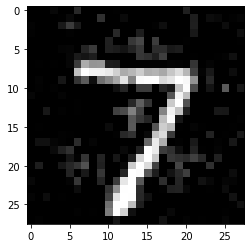

In [11]:
BEST = best + x_test[0]
plt.imshow(BEST.reshape(28,28),cmap='gray')
plt.show()

In [12]:
result=model.predict(best+x_test[0].reshape(1,784))
result[0]

array([3.6929802e-03, 1.4405289e-03, 1.0863394e-01, 4.4544530e-01,
       1.6286361e-04, 1.3179737e-02, 2.9563455e-05, 4.1632634e-01,
       7.4511655e-03, 3.6376177e-03], dtype=float32)

In [13]:
# test
count = 0
for i in range(784):
    if best[i] != 0:
        count+=1
print(count)

488


In [14]:
# test
count = 0
for i in range(784):
    if best[i] > 0.8:
        count+=1
print(count)

0


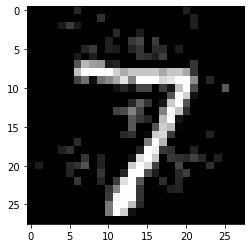

置信度： 0.59691554
[2.5159847e-03 1.0908019e-03 7.4615724e-02 3.0661988e-01 1.3526437e-04
 8.5982438e-03 2.0490968e-05 5.9691554e-01 5.5782753e-03 3.9097611e-03]
扰动程度： 3.9940592798654615


In [21]:
#过滤（低强度）
import copy
x_f = copy.deepcopy(best)
for i in range(784):
    if abs(x_f[i]) < 0.1:
        x_f[i] = 0
f = x_f+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
result=model.predict(f.reshape(1,784))
print("置信度：", result[0][7])
print(result[0])
print("扰动程度：",Dis(x_f))

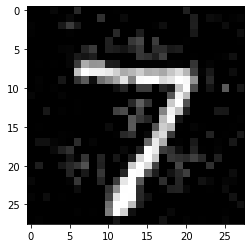

置信度： 0.5147962
[3.81564558e-03 1.32947660e-03 1.08670965e-01 3.51017982e-01
 1.62580487e-04 1.10164434e-02 2.76457831e-05 5.14796197e-01
 5.77141810e-03 3.39172524e-03]
扰动程度： 4.131050613795115


In [17]:
#过滤（高强度）
import copy
x_F = copy.deepcopy(best)
for i in range(784):
    if abs(x_F[i]) > 0.5:
        x_F[i] = 0
F = x_F+x_test[0]
plt.imshow(F.reshape(28,28),cmap='gray')
plt.show()
result=model.predict(F.reshape(1,784))
print("置信度：", result[0][7])
print(result[0])
print("扰动程度：",Dis(x_F))

迭代失败


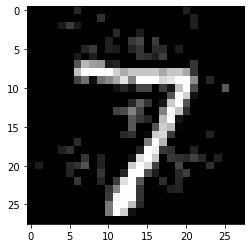

最终置信度： 0.59691554
最终扰动程度： 3.9940592798654615
[2.5159847e-03 1.0908019e-03 7.4615724e-02 3.0661988e-01 1.3526437e-04
 8.5982438e-03 2.0490968e-05 5.9691554e-01 5.5782753e-03 3.9097611e-03]


In [22]:
# 改变坐标减小置信度（过滤0.1）
import copy
x_t = copy.deepcopy(x_f)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])

迭代失败


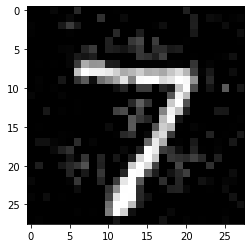

最终置信度： 0.5147962
最终扰动程度： 4.131050613795115
[3.81564558e-03 1.32947660e-03 1.08670965e-01 3.51017982e-01
 1.62580487e-04 1.10164434e-02 2.76457831e-05 5.14796197e-01
 5.77141810e-03 3.39172524e-03]


In [23]:
# 改变坐标减小置信度（过滤0.5）
import copy
x_t = copy.deepcopy(x_F)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])

迭代失败


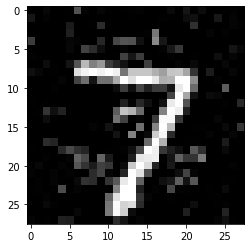

最终置信度： 0.39767227
最终扰动程度： 7.0038201815486
[3.7777259e-03 1.0443135e-03 1.1682559e-01 4.5660120e-01 1.5665211e-04
 1.2439688e-02 3.2627453e-05 3.9767227e-01 7.4698036e-03 3.9801179e-03]


In [11]:
# 改变坐标减小置信度
import copy
x_t = copy.deepcopy(BEST_X)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])